In [1]:
import os
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict

from cl_explain.metrics.ablation import compute_auc

In [2]:
RESULT_PATH = "/projects/leelab/cl-explainability/results"
SUPERPIXEL_ATTRIBUTION_METHODS = ["kernel_shap"]
SEED_LIST = [123, 456, 789, 42, 91]

In [3]:
def get_eval_filename(
    same_class: bool,
    corpus_size: int,
    explanation_name: str,
    foil_size: int,
    explicand_size: int,
    attribution_name: str,
    superpixel_dim: int,
    removal: str,
    blur_strength: float,
    eval_superpixel_dim: int,
    eval_foil_size: int,
    take_attribution_abs: bool,
) -> str:
    """Get eval filename."""
    if same_class:
        eval_filename = "same_class_eval_results"
    else:
        eval_filename = "diff_class_eval_results"
    eval_filename += f"_explicand_size={explicand_size}"
    if "corpus" in explanation_name:
        eval_filename += f"_corpus_size={corpus_size}"
    if "contrastive" in explanation_name:
        eval_filename += f"_foil_size={foil_size}"
    if attribution_name in SUPERPIXEL_ATTRIBUTION_METHODS:
        eval_filename += f"_superpixel_dim={superpixel_dim}"
    eval_filename += f"_removal={removal}"
    if removal == "blurring":
        eval_filename += f"_blur_strength={blur_strength:.1f}"
    eval_filename += f"_eval_superpixel_dim={eval_superpixel_dim}"
    eval_filename += f"_eval_foil_size={eval_foil_size}"
    if take_attribution_abs:
        eval_filename += "_abs"
    eval_filename += ".pkl"
    return eval_filename


def get_mean_curves(outputs, curve_kind) -> Tuple[List[torch.Tensor], int]:
    available_curve_kinds = ["insertion", "deletion"]
    assert curve_kind in available_curve_kinds, (
        f"curve_kind={curve_kind} is not one of {available_curve_kinds}!"
    )
    target_list = [key for key in outputs.keys()]
    eval_name_list = (
        outputs[target_list[0]]["eval_model_names"]
        + outputs[target_list[0]]["eval_measure_names"]
    )
    eval_mean_curve_dict = {}
    for j, eval_name in enumerate(eval_name_list):
        
        curve_list = []
        num_features = None

        for target, output in outputs.items():
            target_curve_list = (
                output[f"model_{curve_kind}_curves"]
                + output[f"measure_{curve_kind}_curves"]
            )
            curve_list.append(target_curve_list[j])
            num_features = output[f"{curve_kind}_num_features"]
        
        curves = torch.cat(curve_list)
        mean_curve = curves.mean(dim=0).cpu()
        eval_mean_curve_dict[eval_name] = mean_curve
        
    return eval_mean_curve_dict, num_features


def get_mean_aucs(outputs, curve_kind) -> Dict[str, float]:
    available_curve_kinds = ["insertion", "deletion"]
    assert curve_kind in available_curve_kinds, (
        f"curve_kind={curve_kind} is not one of {available_curve_kinds}!"
    )
    target_list = [key for key in outputs.keys()]
    eval_name_list = (
        outputs[target_list[0]]["eval_model_names"]
        + outputs[target_list[0]]["eval_measure_names"]
    )
    mean_auc_dict = {}
    for j, eval_name in enumerate(eval_name_list):
        
        curve_list = []
        num_features = None

        for target, output in outputs.items():
            target_curve_list = (
                output[f"model_{curve_kind}_curves"]
                + output[f"measure_{curve_kind}_curves"]
            )
            curve_list.append(target_curve_list[j])
            num_features = output[f"{curve_kind}_num_features"]
        
        curves = torch.cat(curve_list)
        mean_curve = curves.mean(dim=0).cpu()
        mean_auc = compute_auc(mean_curve, num_features)
        mean_auc_dict[eval_name] = mean_auc.numpy()
    return mean_auc_dict


def get_auc_stats(
    dataset: str,
    encoder: str,
    explanation: str,
    attribution: str,
    eval_name_list: List[str],
    seed_list: List[int],
    normalize_similarity: bool,
    **get_eval_filename_kwargs,
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, float]]]:
    all_insertion_auc_dict = {eval_name: [] for eval_name in eval_name_list}
    all_deletion_auc_dict = {eval_name: [] for eval_name in eval_name_list}
    for seed in seed_list:
        eval_filename = get_eval_filename(
            explanation_name=explanation,
            attribution_name=attribution,
            **get_eval_filename_kwargs,
        )
        if normalize_similarity:
            method_name = f"normalized_{explanation}_{attribution}"
        else:
            method_name = f"unnormalized_{explanation}_{attribution}"
        with open(
            os.path.join(
                RESULT_PATH,
                dataset,
                encoder,
                method_name,
                f"{seed}",
                eval_filename,
            ),
            "rb",
        ) as handle:
            outputs = pickle.load(handle)

        insertion_auc_dict = get_mean_aucs(outputs, "insertion")
        deletion_auc_dict = get_mean_aucs(outputs, "deletion")
        for eval_name in eval_name_list:
            all_insertion_auc_dict[eval_name].append(insertion_auc_dict[eval_name])
            all_deletion_auc_dict[eval_name].append(deletion_auc_dict[eval_name])

    insertion_auc_stats_dict = {eval_name: {} for eval_name in eval_name_list}
    deletion_auc_stats_dict = {eval_name: {} for eval_name in eval_name_list}
    for eval_name in eval_name_list:
        insertion_auc_stats_dict[eval_name]["mean"] = np.mean(all_insertion_auc_dict[eval_name])
        insertion_auc_stats_dict[eval_name]["std"] = np.std(all_insertion_auc_dict[eval_name])
        insertion_auc_stats_dict[eval_name]["ci"] = (
            1.96 * insertion_auc_stats_dict[eval_name]["std"] / np.sqrt(len(seed_list))
        )
        deletion_auc_stats_dict[eval_name]["mean"] = np.mean(all_deletion_auc_dict[eval_name])
        deletion_auc_stats_dict[eval_name]["std"] = np.std(all_deletion_auc_dict[eval_name])
        deletion_auc_stats_dict[eval_name]["ci"] = (
            1.96 * deletion_auc_stats_dict[eval_name]["std"] / np.sqrt(len(seed_list))
        )
    return insertion_auc_stats_dict, deletion_auc_stats_dict


def format_eval_name(name):
    format_map = {
        "corpus_cosine_similarity": "Cosine similarity to corpus",
        "contrastive_corpus_cosine_similarity": "Cosine similarity to corpus vs. foil",
        "corpus_majority_prob": "Predicted probability of corpus majority",
        "explicand_pred_prob": "Predicted probability of explicand",
        "explicand_rep_shift": "Representation shift of explicand",
    }
    return format_map[name]


def format_explanation_name(name):
    format_map = {
        "self_weighted": "Labe-Free",
        "contrastive_self_weighted": "Contrastive",
        "corpus": "Corpus",
        "contrastive_corpus": "Contrastive Corpus",
    }
    return format_map[name]


def format_attribution_name(name):
    format_map = {
        "gradient_shap": "Gradient Shap",
        "int_grad": "Integrated Gradient",
        "vanilla_grad": "Vanilla Gradient",
        "random_baseline": "Random",
        "rise": "RISE",
    }
    return format_map[name]


def format_dataset_name(name):
    format_map = {
        "imagenet": "Imagenet",
        "cifar": "CIFAR-10",
        "mura": "MURA",
    }
    return format_map[name]

In [4]:
explanation_colors = {
    "corpus": "tab:blue",
    "contrastive_corpus": "tab:red",
}

In [5]:
corpus_size_list = [5, 20, 50, 100, 200]
dataset_meta_dict = {
    "imagenet": {"encoder": "simclr_x1", "removal": "blurring"},
    "cifar": {"encoder": "simsiam_18", "removal": "blurring"},
    "mura": {"encoder": "classifier_18", "removal": "blurring"},
}
explicand_size = 25
blur_strength = 5.0
superpixel_dim = 1
eval_superpixel_dim = 1
foil_size = 1500
eval_foil_size = 1500
take_attribution_abs = False
normalize_similarity = True

explanation_list = ["corpus", "contrastive_corpus"]
attribution_list = ["int_grad", "gradient_shap", "rise"]
eval_name_list = ["corpus_majority_prob", "explicand_pred_prob"]

In [6]:
def lineplot_results(
    dataset,
    eval_name,
    insertion_auc_dict,
    deletion_auc_dict,
    same_class,
    fontsize=14,
    plot_overall_title=True,
    plot_legend=True,
):
    capsize = 5
    fig, axes = plt.subplots(ncols=len(attribution_list), nrows=2, figsize=(24, 12))
    formatted_dataset = format_dataset_name(dataset)
    formatted_eval_name = format_eval_name(eval_name)
    
    for i, attribution in enumerate(attribution_list):
        formatted_attribution = format_attribution_name(attribution)
        for explanation in explanation_list:
            formatted_explanation = format_explanation_name(explanation)
            method_name = f"{formatted_explanation} {formatted_attribution}"
            insertion_auc_means = [
                insertion_auc_dict[dataset][explanation][attribution][corpus_size][eval_name]["mean"]
                for corpus_size in corpus_size_list
            ]
            insertion_auc_cis = [
                insertion_auc_dict[dataset][explanation][attribution][corpus_size][eval_name]["ci"]
                for corpus_size in corpus_size_list
            ]
            deletion_auc_means = [
                deletion_auc_dict[dataset][explanation][attribution][corpus_size][eval_name]["mean"]
                for corpus_size in corpus_size_list
            ]
            deletion_auc_cis = [
                deletion_auc_dict[dataset][explanation][attribution][corpus_size][eval_name]["ci"]
                for corpus_size in corpus_size_list
            ]
            axes[0, i].errorbar(
                corpus_size_list,
                insertion_auc_means,
                yerr=insertion_auc_cis,
                color=explanation_colors[explanation],
                linestyle="solid",
                marker="o",
                capsize=capsize,
                label=formatted_explanation,
            )
            axes[0, i].set_xlabel("Corpus size", fontsize=fontsize)
            axes[0, i].set_ylabel(f"{formatted_dataset} insertion AUC", fontsize=fontsize)
            axes[0, i].set_title(formatted_attribution, fontsize=fontsize)
            
            axes[1, i].errorbar(
                corpus_size_list,
                deletion_auc_means,
                yerr=deletion_auc_cis,
                color=explanation_colors[explanation],
                linestyle="solid",
                marker="o",
                capsize=capsize,
                label=formatted_explanation,
            )
            axes[1, i].set_xlabel("Corpus size", fontsize=fontsize)
            axes[1, i].set_ylabel(f"{formatted_dataset} deletion AUC", fontsize=fontsize)
            axes[1, i].set_title(formatted_attribution, fontsize=fontsize)
    if plot_legend:
        axes[0, 0].legend(loc="lower right", fontsize=fontsize)
    title = formatted_eval_name
    if same_class:
        title += "\n(Explicands and corpus belong to the same class)\n"
    else:
        title += "\n(Explicands and corpus belong to different classes)\n"
    if plot_overall_title:
        plt.suptitle(title, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

In [7]:
insertion_auc_dict = {}
deletion_auc_dict = {}

for dataset, meta_dict in dataset_meta_dict.items():
    insertion_auc_dict[dataset] = {}
    deletion_auc_dict[dataset] = {}
    encoder = meta_dict["encoder"]
    removal = meta_dict["removal"]
    
    for explanation in explanation_list:
        insertion_auc_dict[dataset][explanation] = {}
        deletion_auc_dict[dataset][explanation] = {}
        
        for attribution in attribution_list:
            insertion_auc_dict[dataset][explanation][attribution] = {}
            deletion_auc_dict[dataset][explanation][attribution] = {}
            
            for corpus_size in corpus_size_list:
                insertion_stats_dict, deletion_stats_dict = get_auc_stats(
                    dataset,
                    encoder,
                    explanation,
                    attribution,
                    eval_name_list,
                    SEED_LIST,
                    normalize_similarity,
                    same_class=True,  # Make sure this is True.
                    corpus_size=corpus_size,
                    foil_size=foil_size,
                    explicand_size=explicand_size,
                    superpixel_dim=superpixel_dim,
                    removal=removal,
                    blur_strength=blur_strength,
                    eval_superpixel_dim=eval_superpixel_dim,
                    eval_foil_size=eval_foil_size,
                    take_attribution_abs=take_attribution_abs,
                )
                insertion_auc_dict[dataset][explanation][attribution][corpus_size] = insertion_stats_dict
                deletion_auc_dict[dataset][explanation][attribution][corpus_size] = deletion_stats_dict

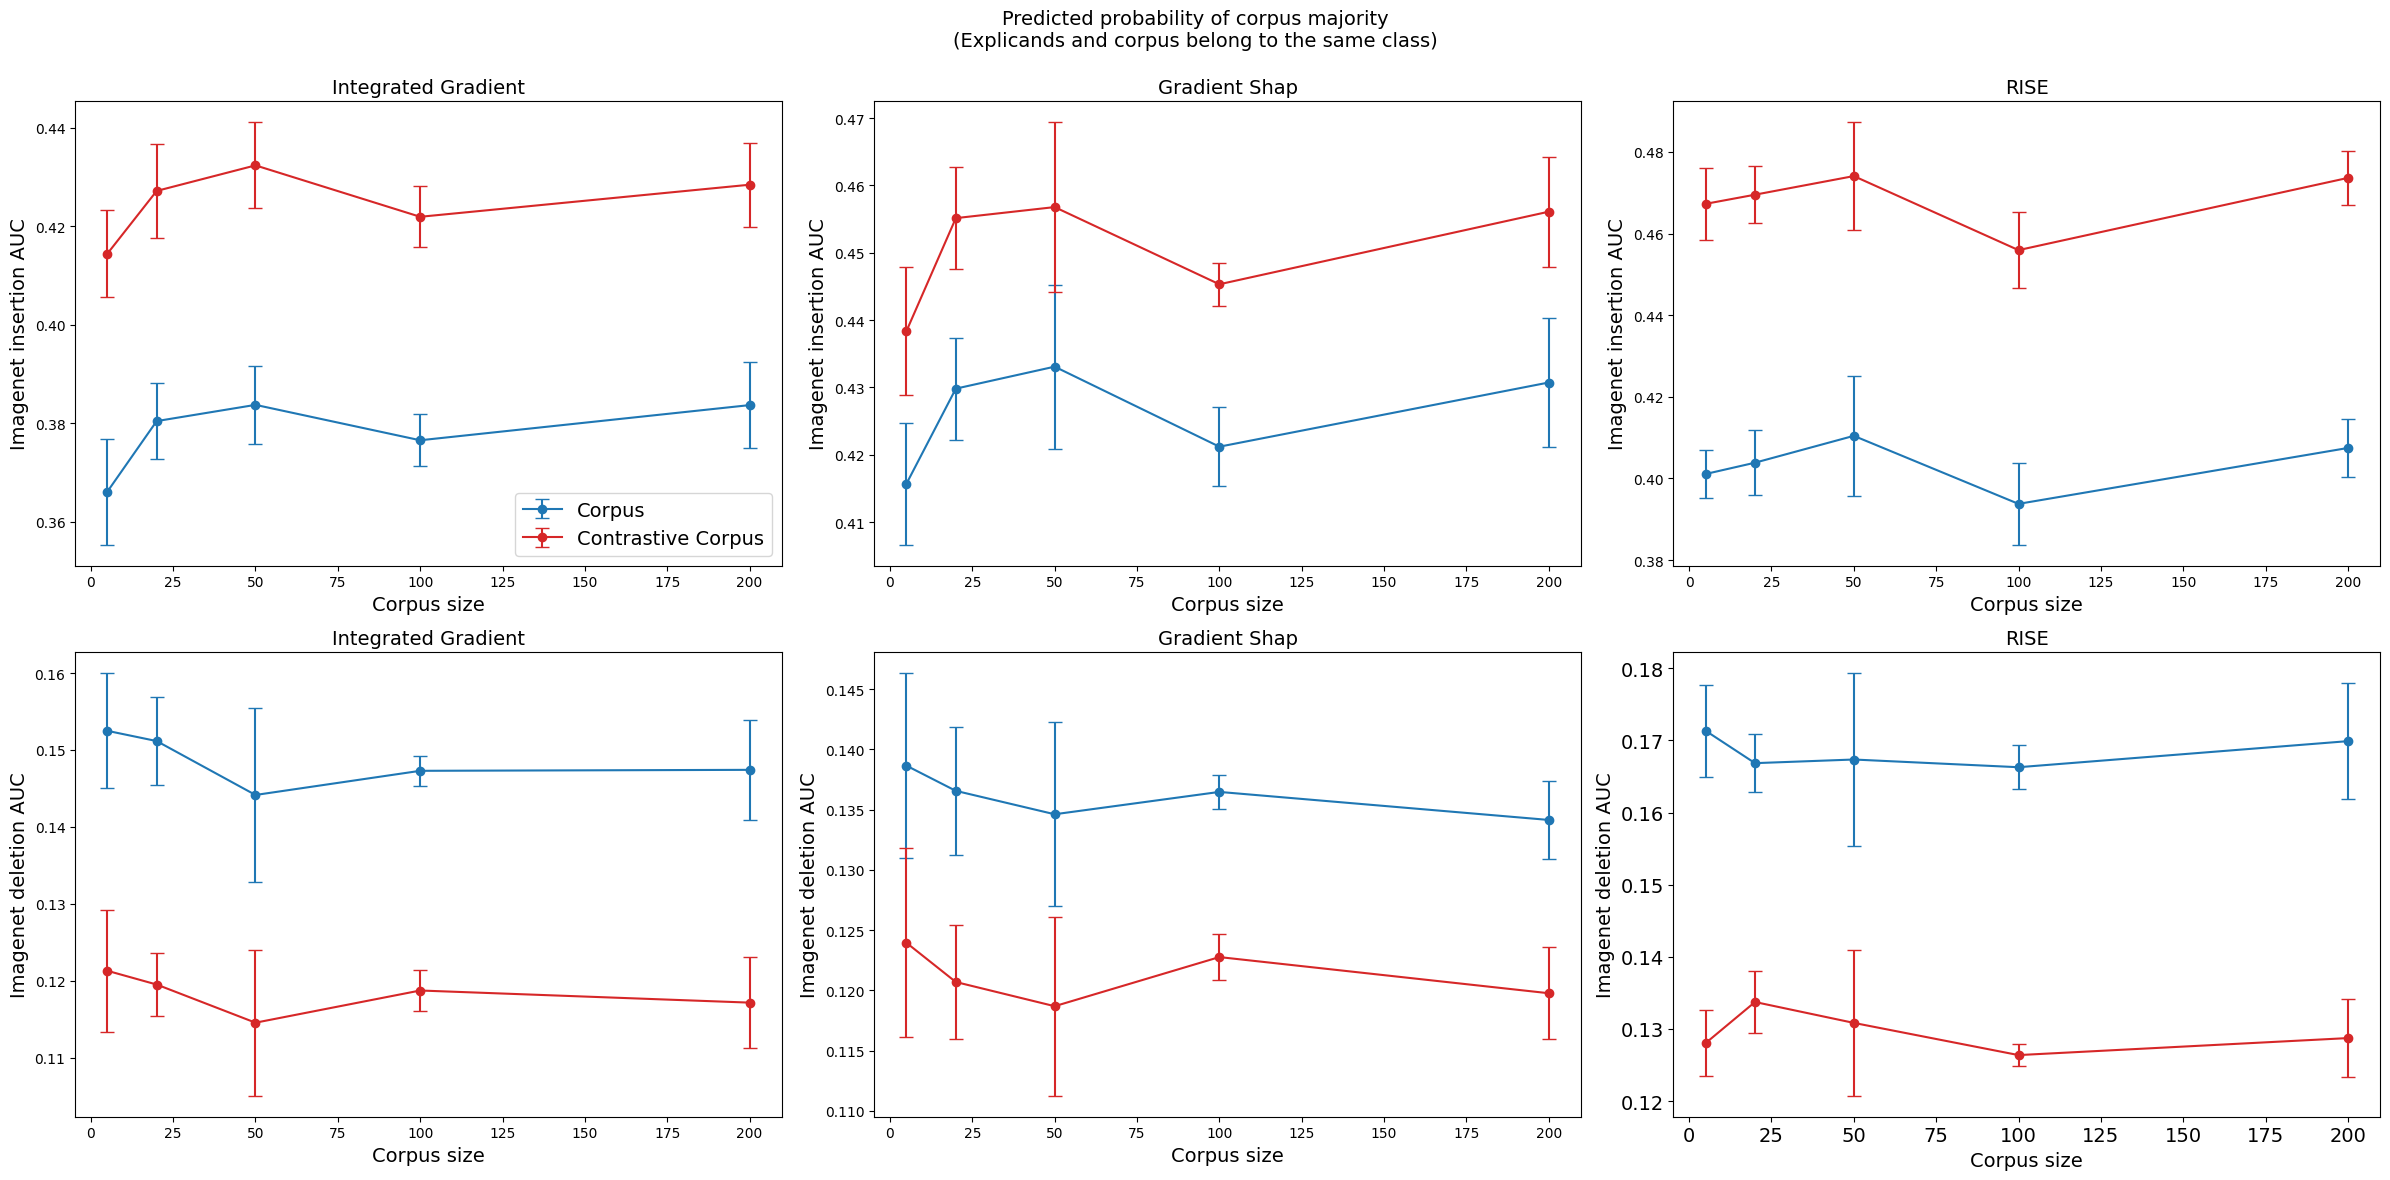

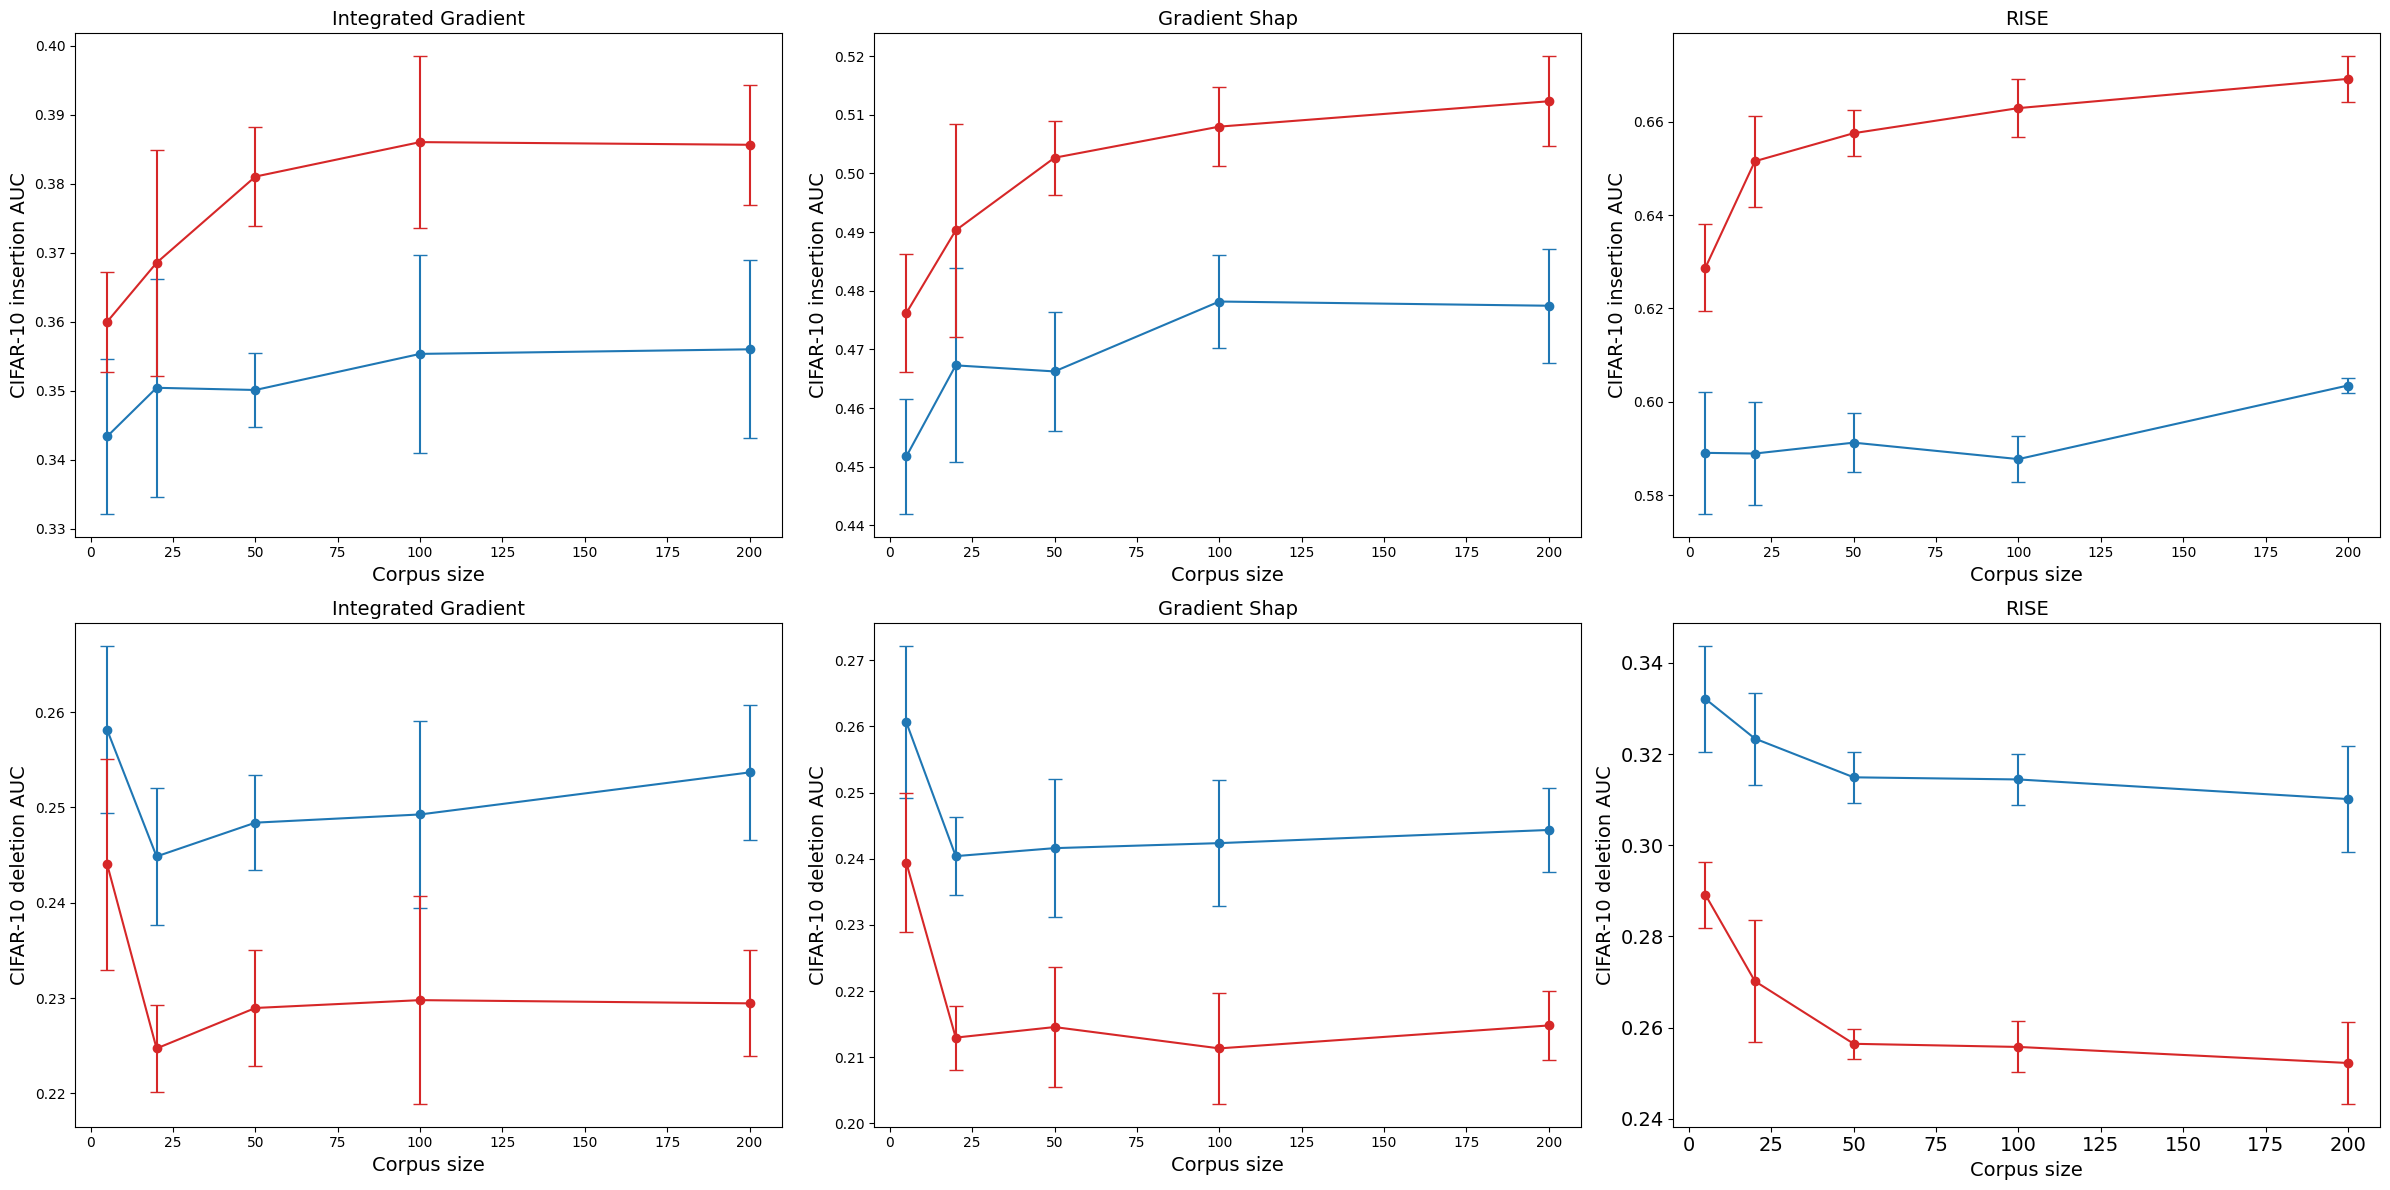

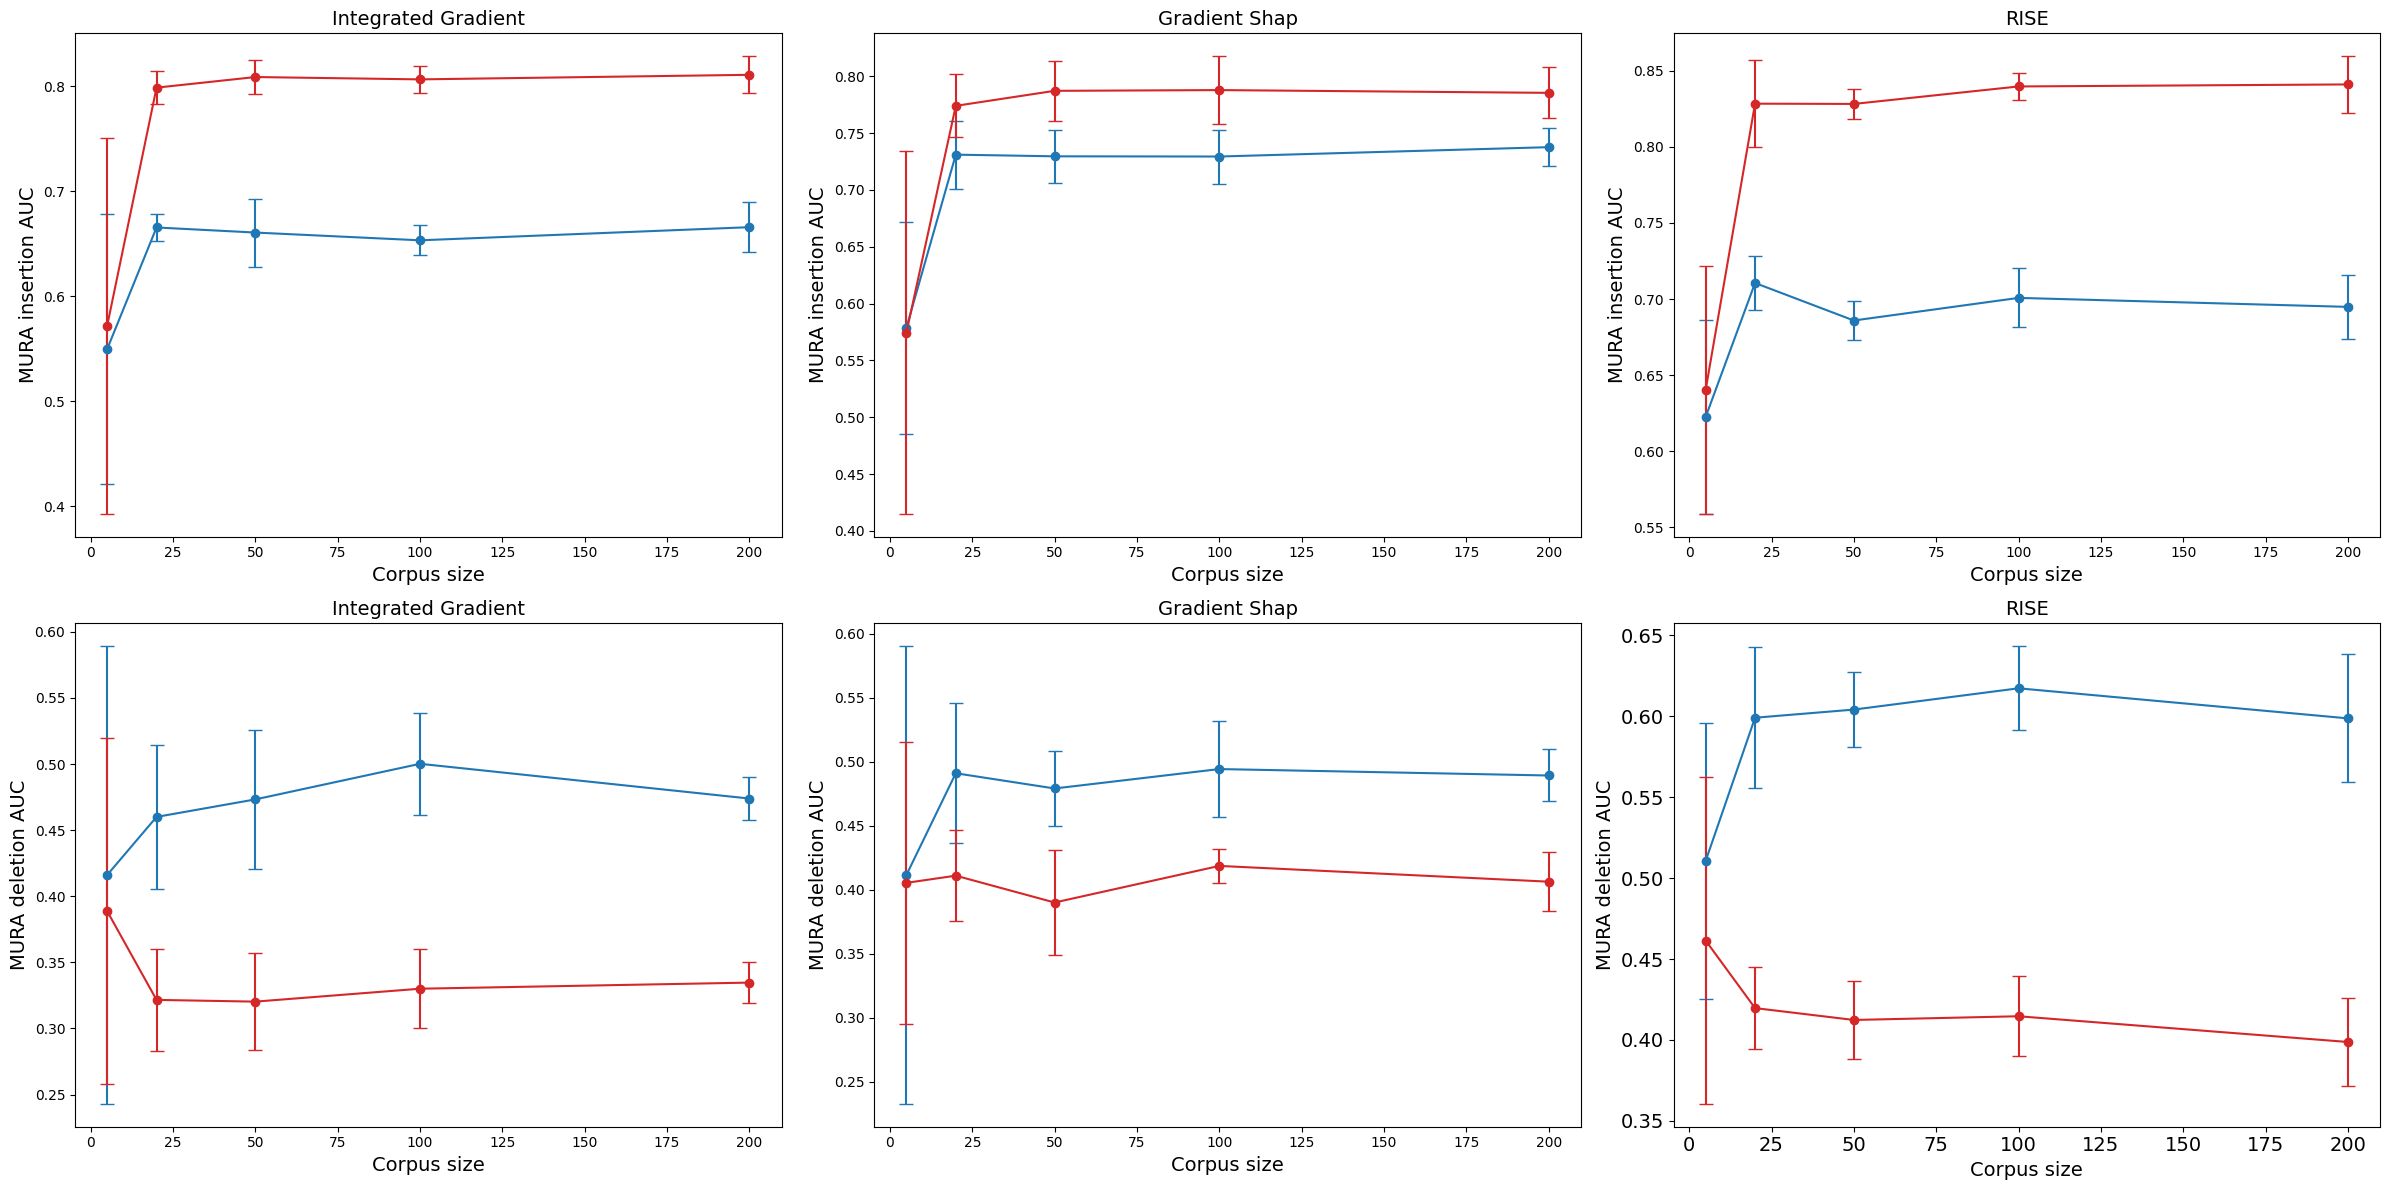

In [8]:
for i, dataset in enumerate(dataset_meta_dict.keys()):
    plot_extra = i == 0
    lineplot_results(
        dataset=dataset,
        eval_name="corpus_majority_prob",
        insertion_auc_dict=insertion_auc_dict,
        deletion_auc_dict=deletion_auc_dict,
        same_class=True,
        fontsize=14,
        plot_overall_title=plot_extra,
        plot_legend=plot_extra,
    )

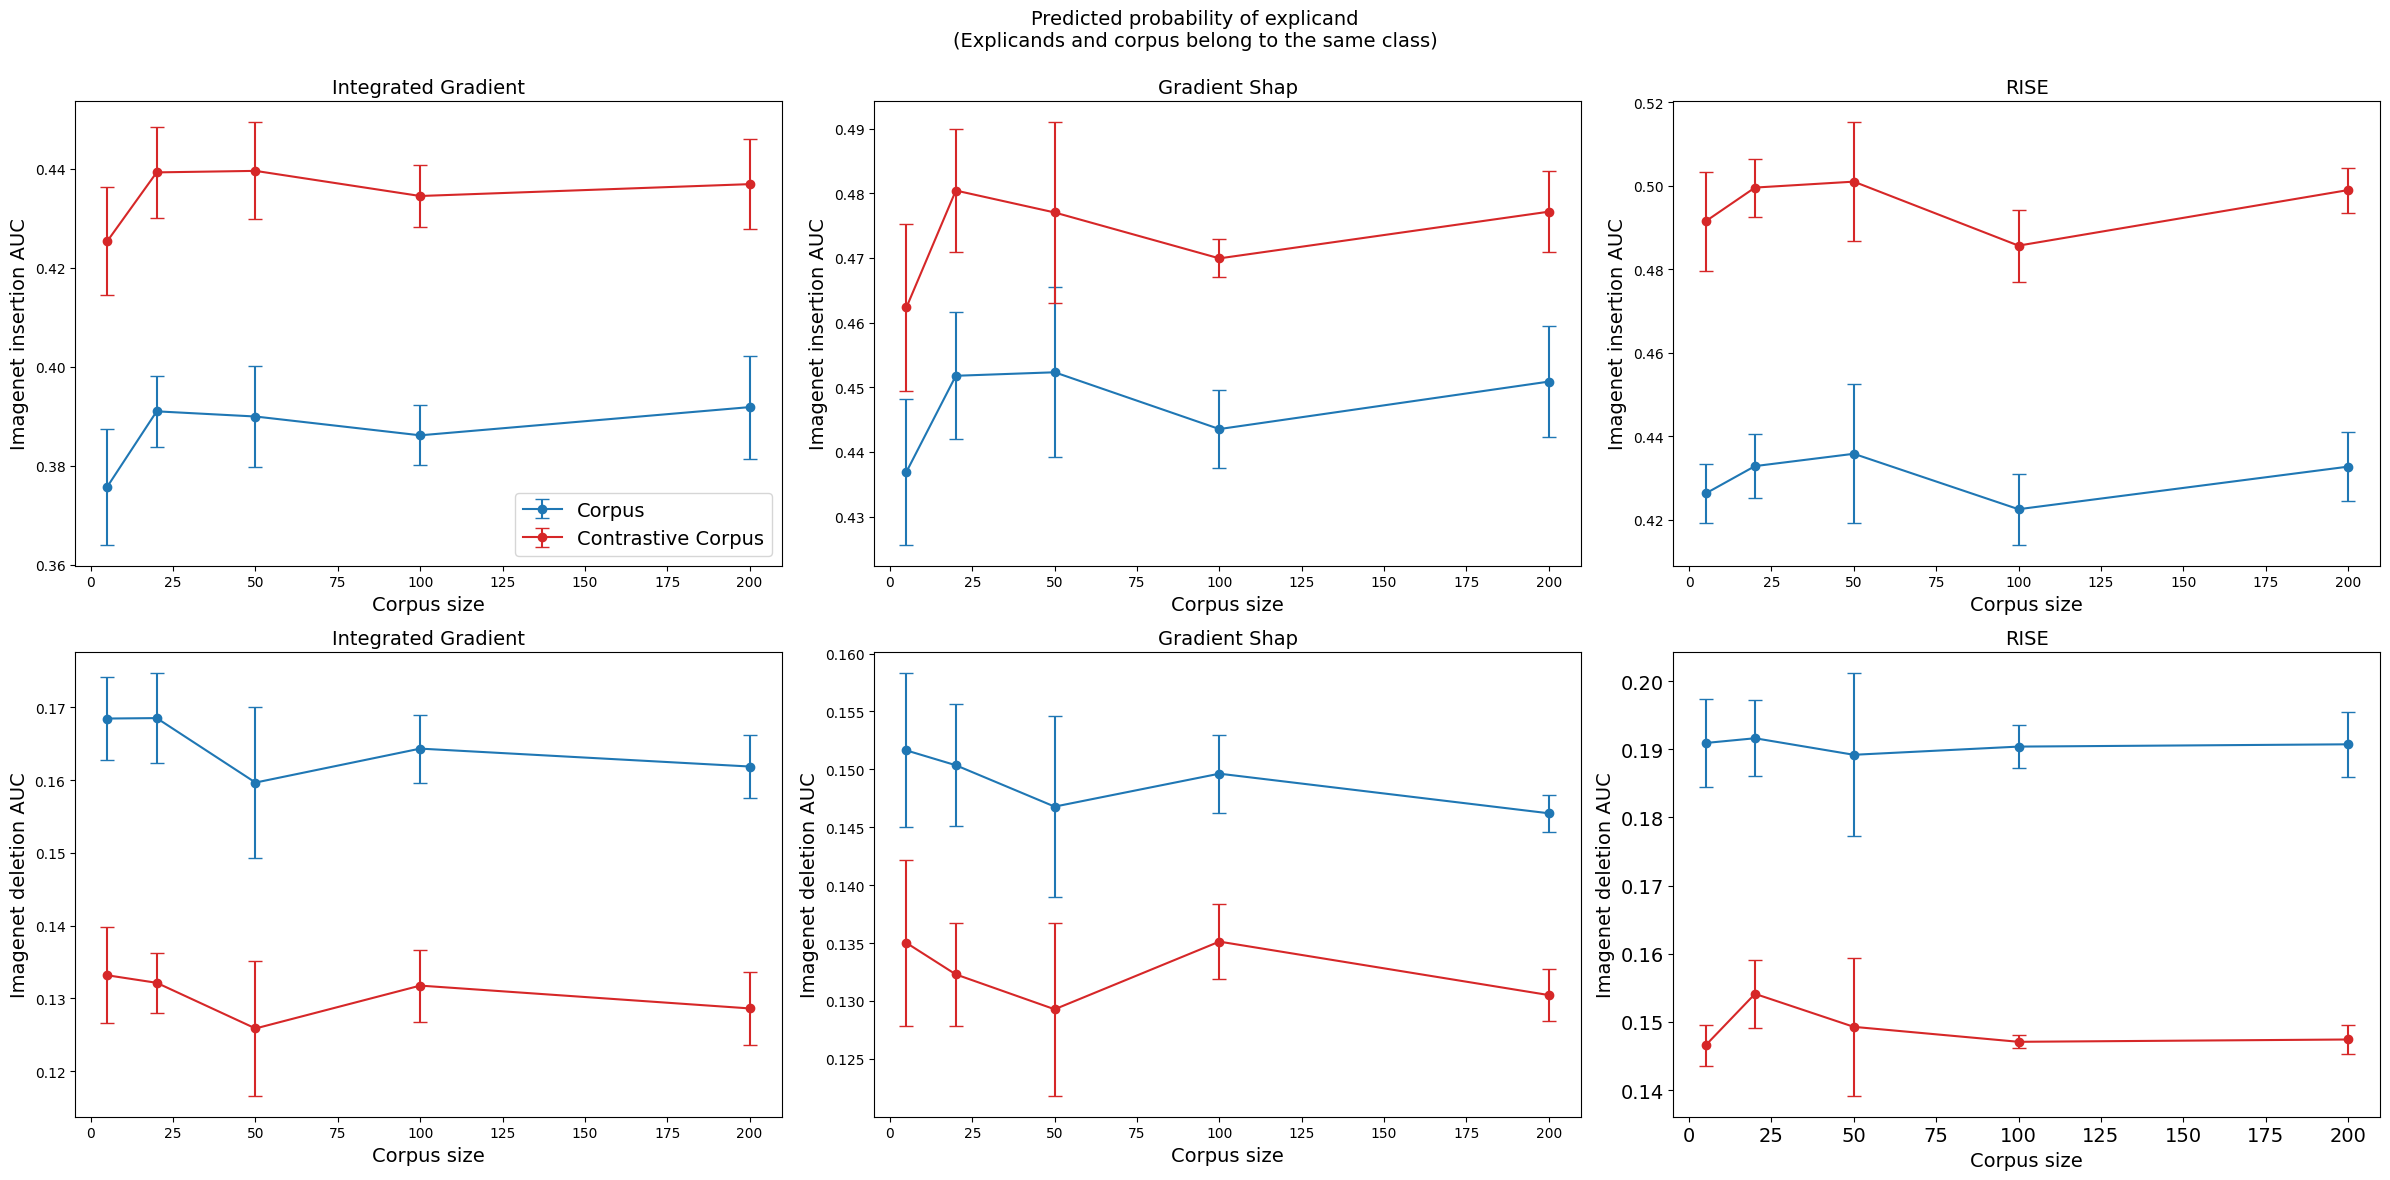

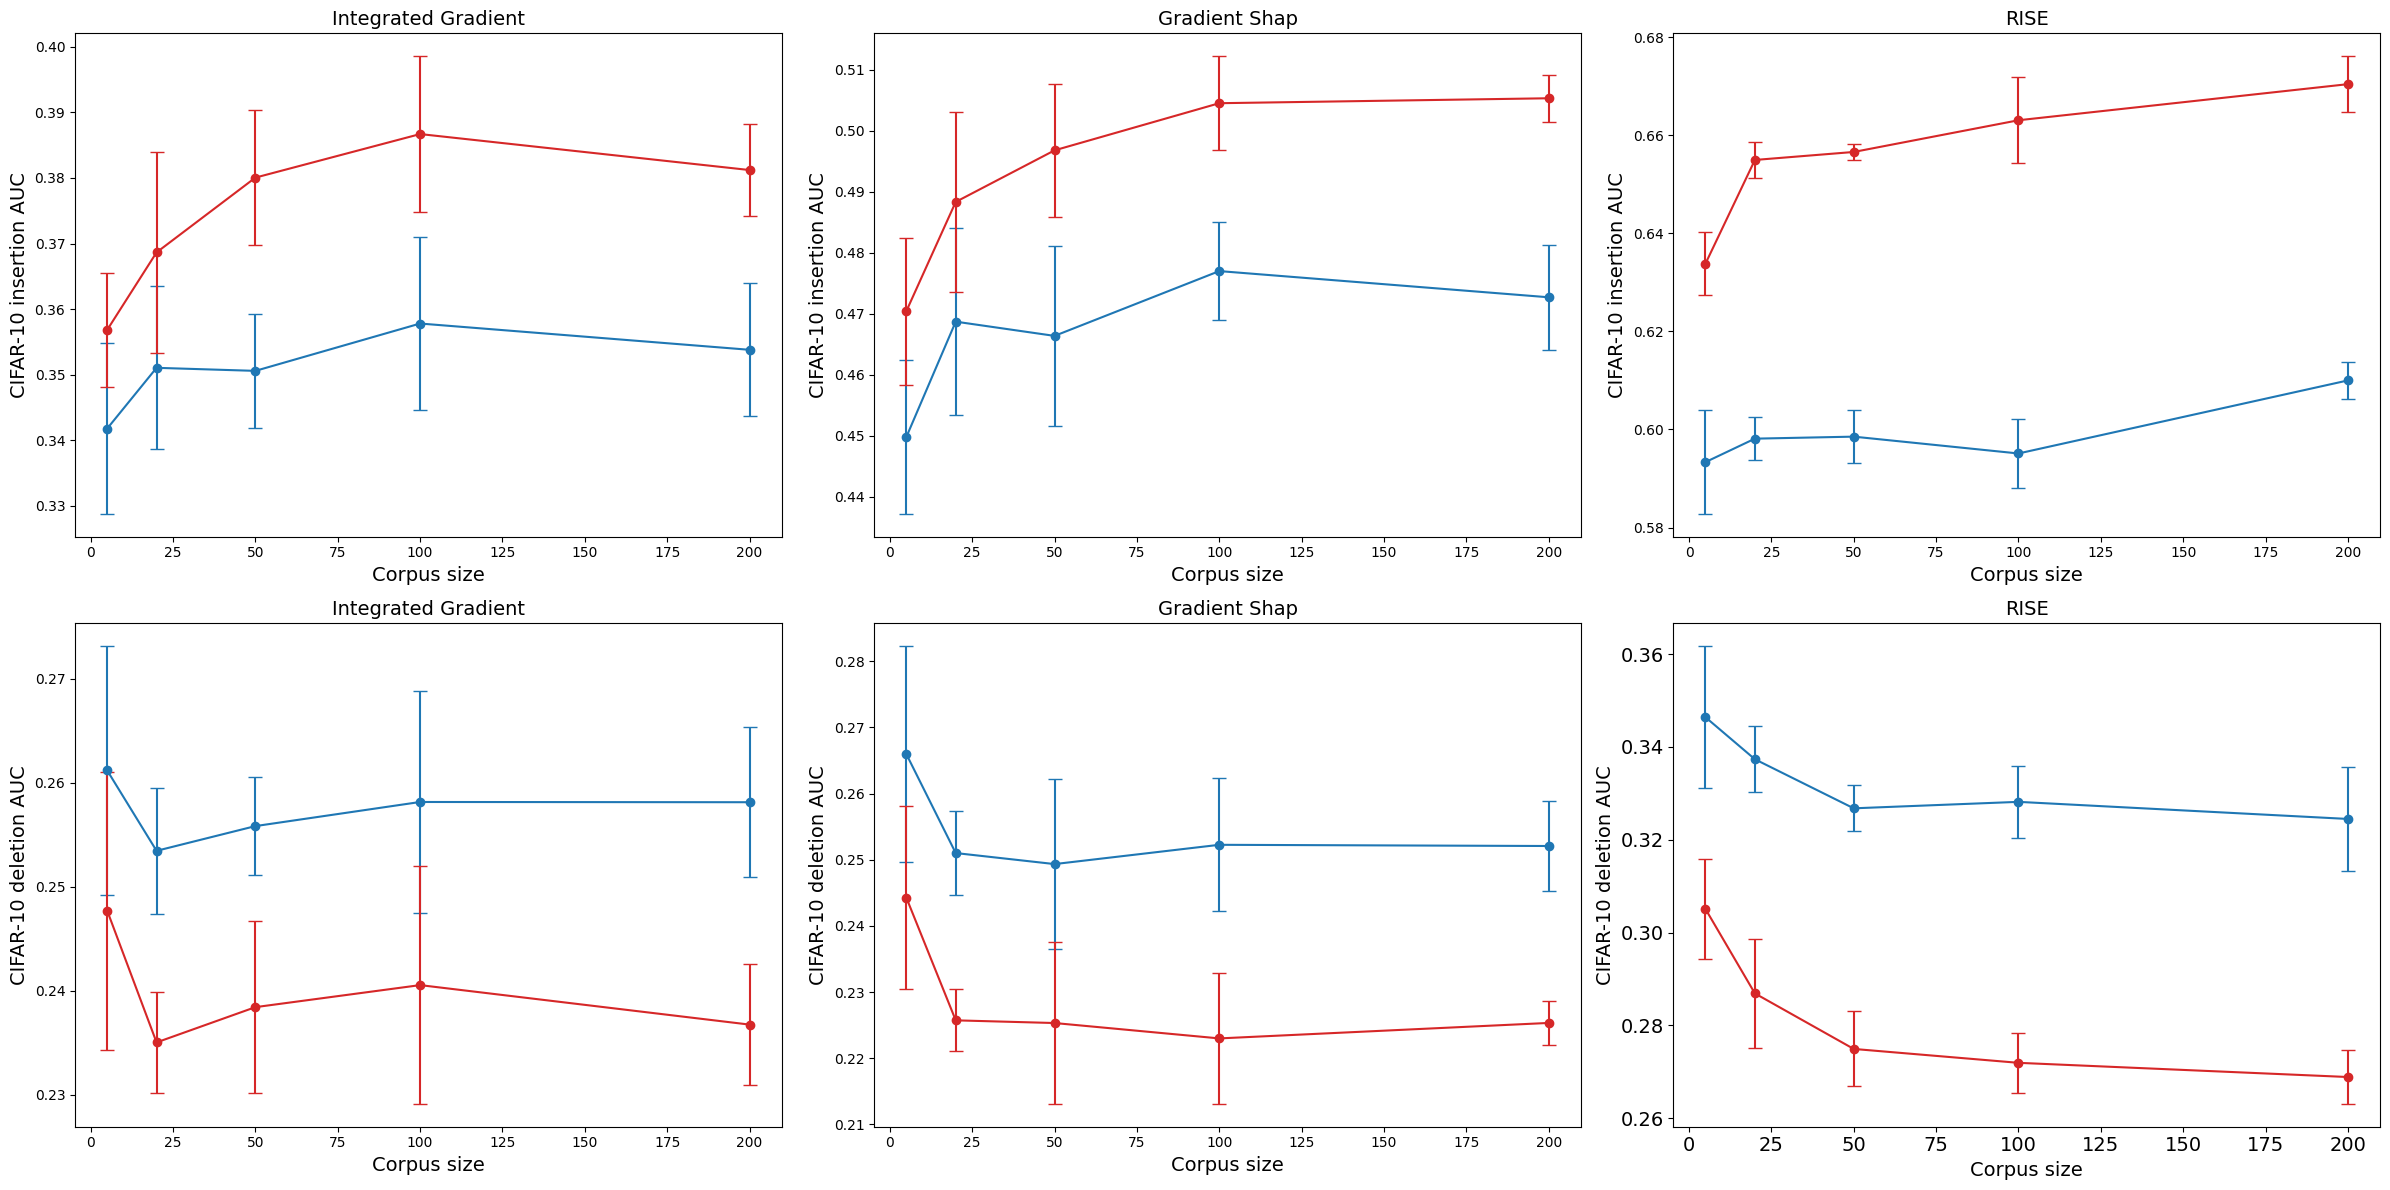

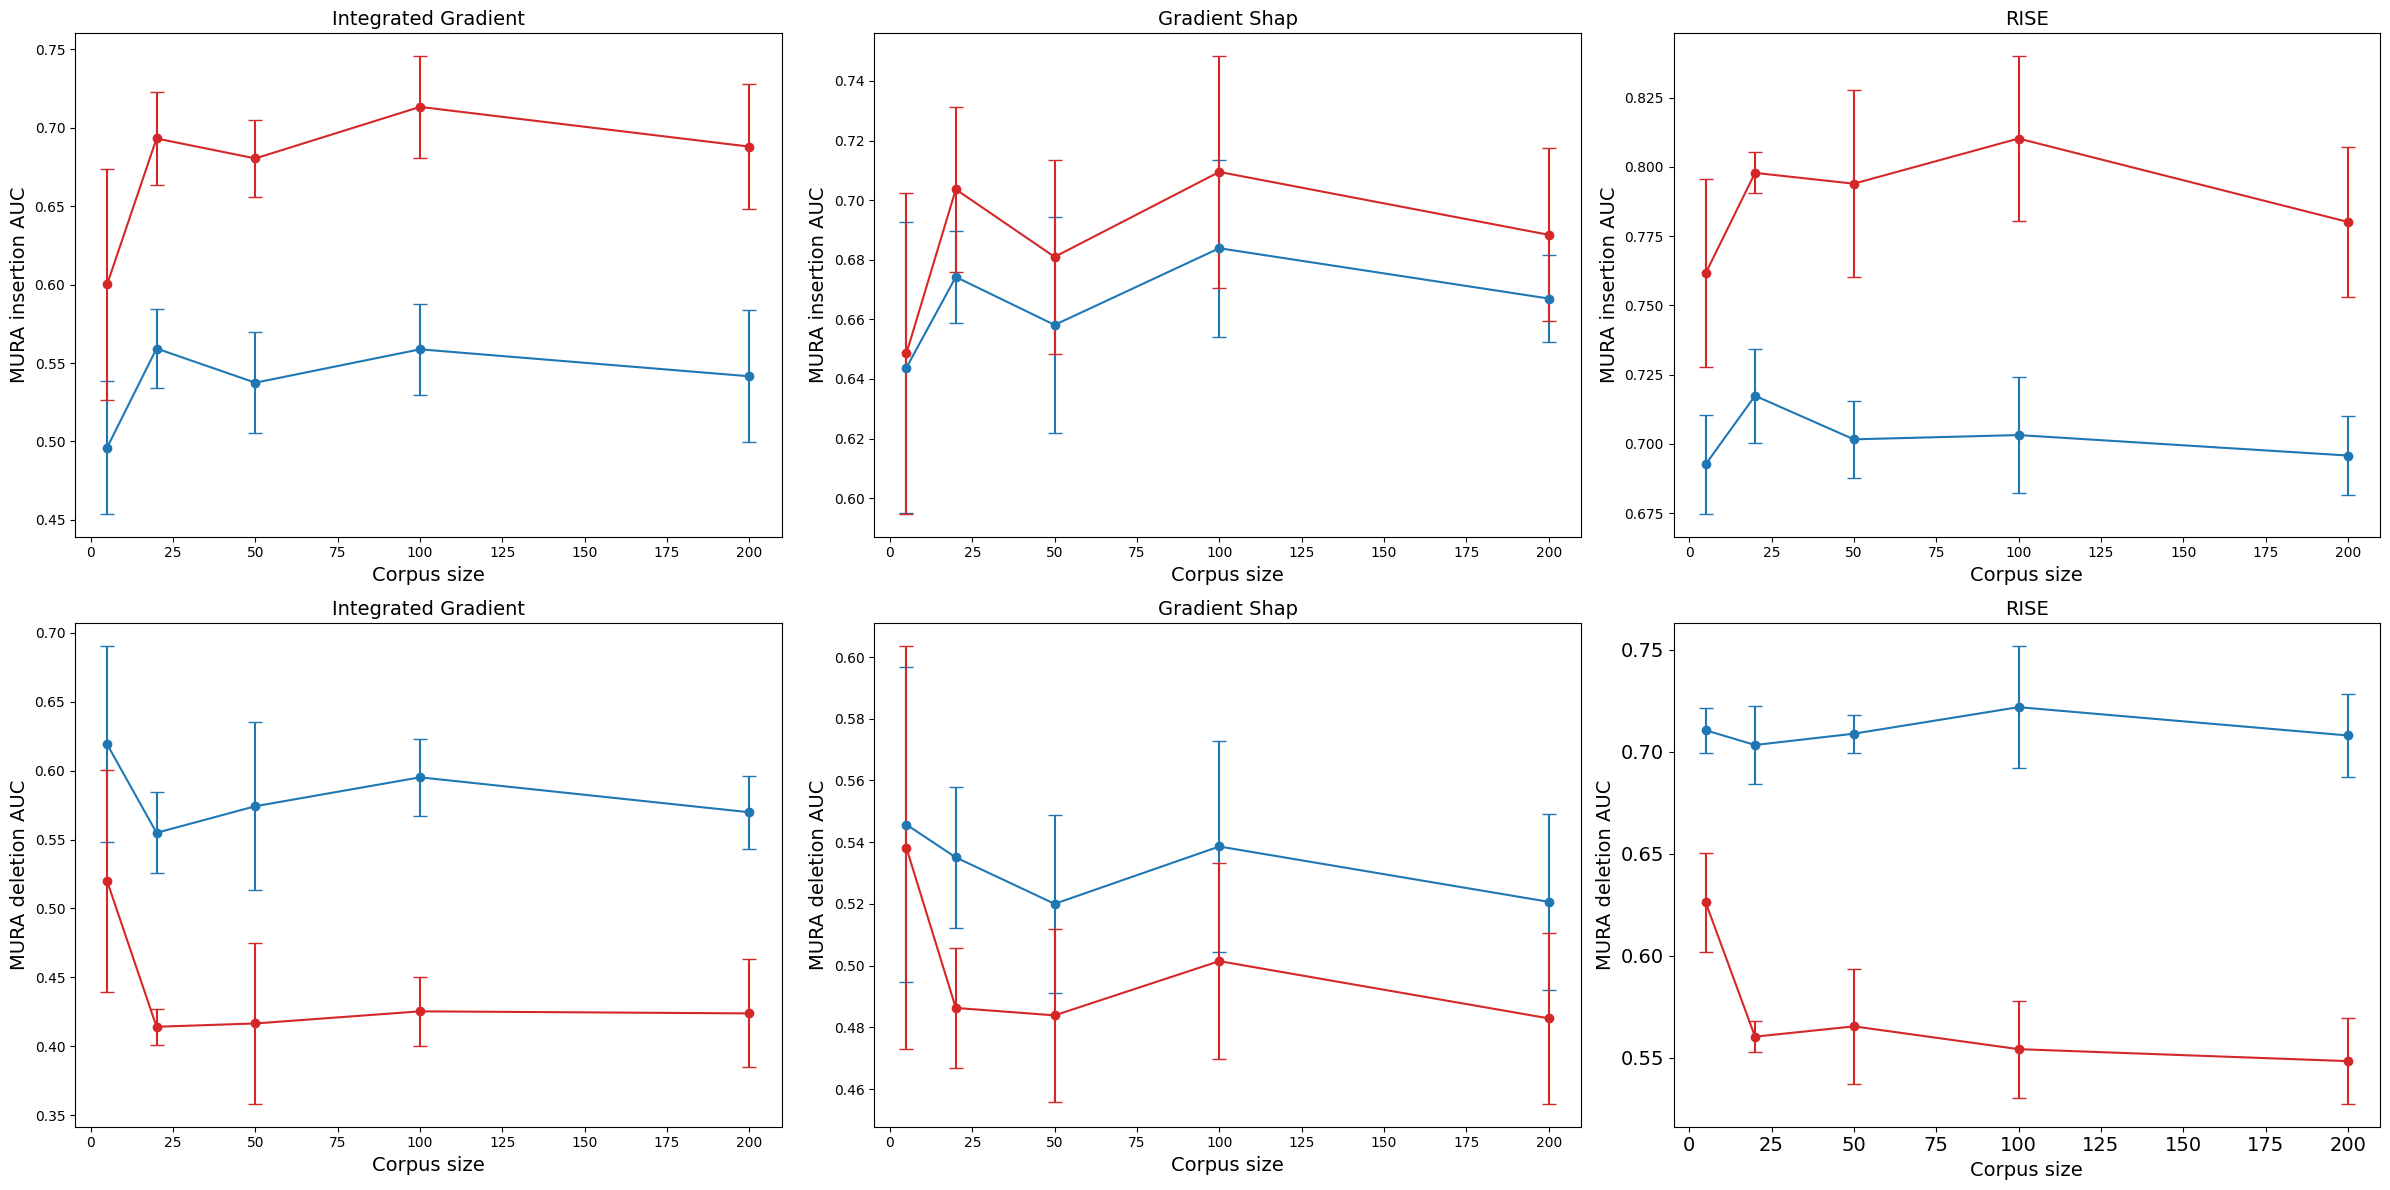

In [9]:
for i, dataset in enumerate(dataset_meta_dict.keys()):
    plot_extra = i == 0
    lineplot_results(
        dataset=dataset,
        eval_name="explicand_pred_prob",
        insertion_auc_dict=insertion_auc_dict,
        deletion_auc_dict=deletion_auc_dict,
        same_class=True,
        fontsize=14,
        plot_overall_title=plot_extra,
        plot_legend=plot_extra,
    )

In [10]:
insertion_auc_dict = {}
deletion_auc_dict = {}

for dataset, meta_dict in dataset_meta_dict.items():
    insertion_auc_dict[dataset] = {}
    deletion_auc_dict[dataset] = {}
    encoder = meta_dict["encoder"]
    removal = meta_dict["removal"]
    
    for explanation in explanation_list:
        insertion_auc_dict[dataset][explanation] = {}
        deletion_auc_dict[dataset][explanation] = {}
        
        for attribution in attribution_list:
            insertion_auc_dict[dataset][explanation][attribution] = {}
            deletion_auc_dict[dataset][explanation][attribution] = {}
            
            for corpus_size in corpus_size_list:
                insertion_stats_dict, deletion_stats_dict = get_auc_stats(
                    dataset,
                    encoder,
                    explanation,
                    attribution,
                    eval_name_list,
                    SEED_LIST,
                    normalize_similarity,
                    same_class=False,  # Make sure this is False.
                    corpus_size=corpus_size,
                    foil_size=foil_size,
                    explicand_size=explicand_size,
                    superpixel_dim=superpixel_dim,
                    removal=removal,
                    blur_strength=blur_strength,
                    eval_superpixel_dim=eval_superpixel_dim,
                    eval_foil_size=eval_foil_size,
                    take_attribution_abs=take_attribution_abs,
                )
                insertion_auc_dict[dataset][explanation][attribution][corpus_size] = insertion_stats_dict
                deletion_auc_dict[dataset][explanation][attribution][corpus_size] = deletion_stats_dict

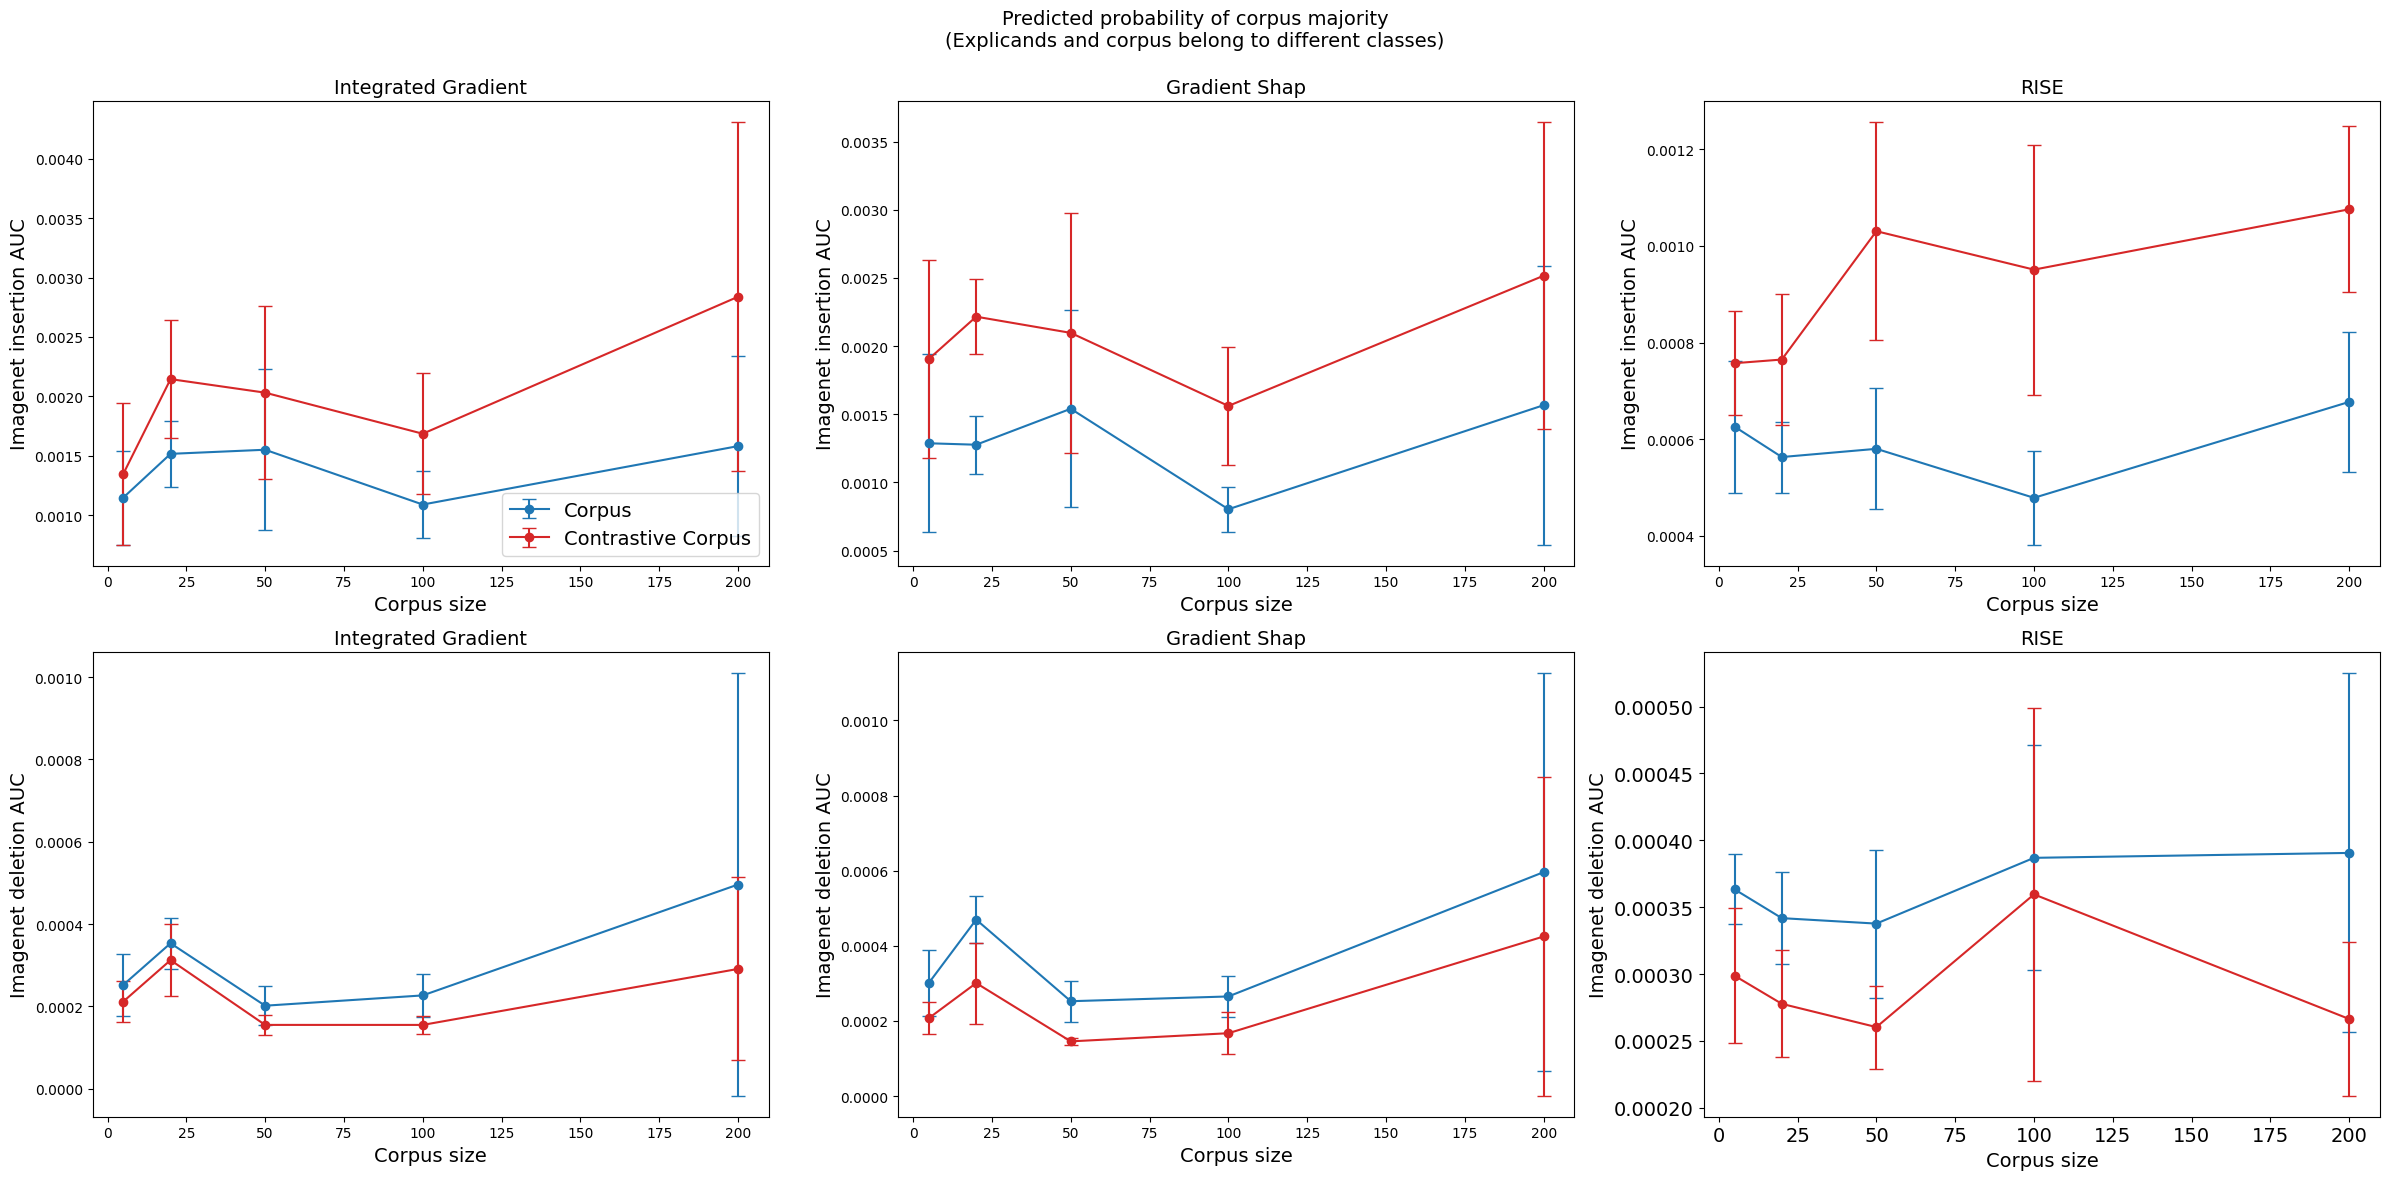

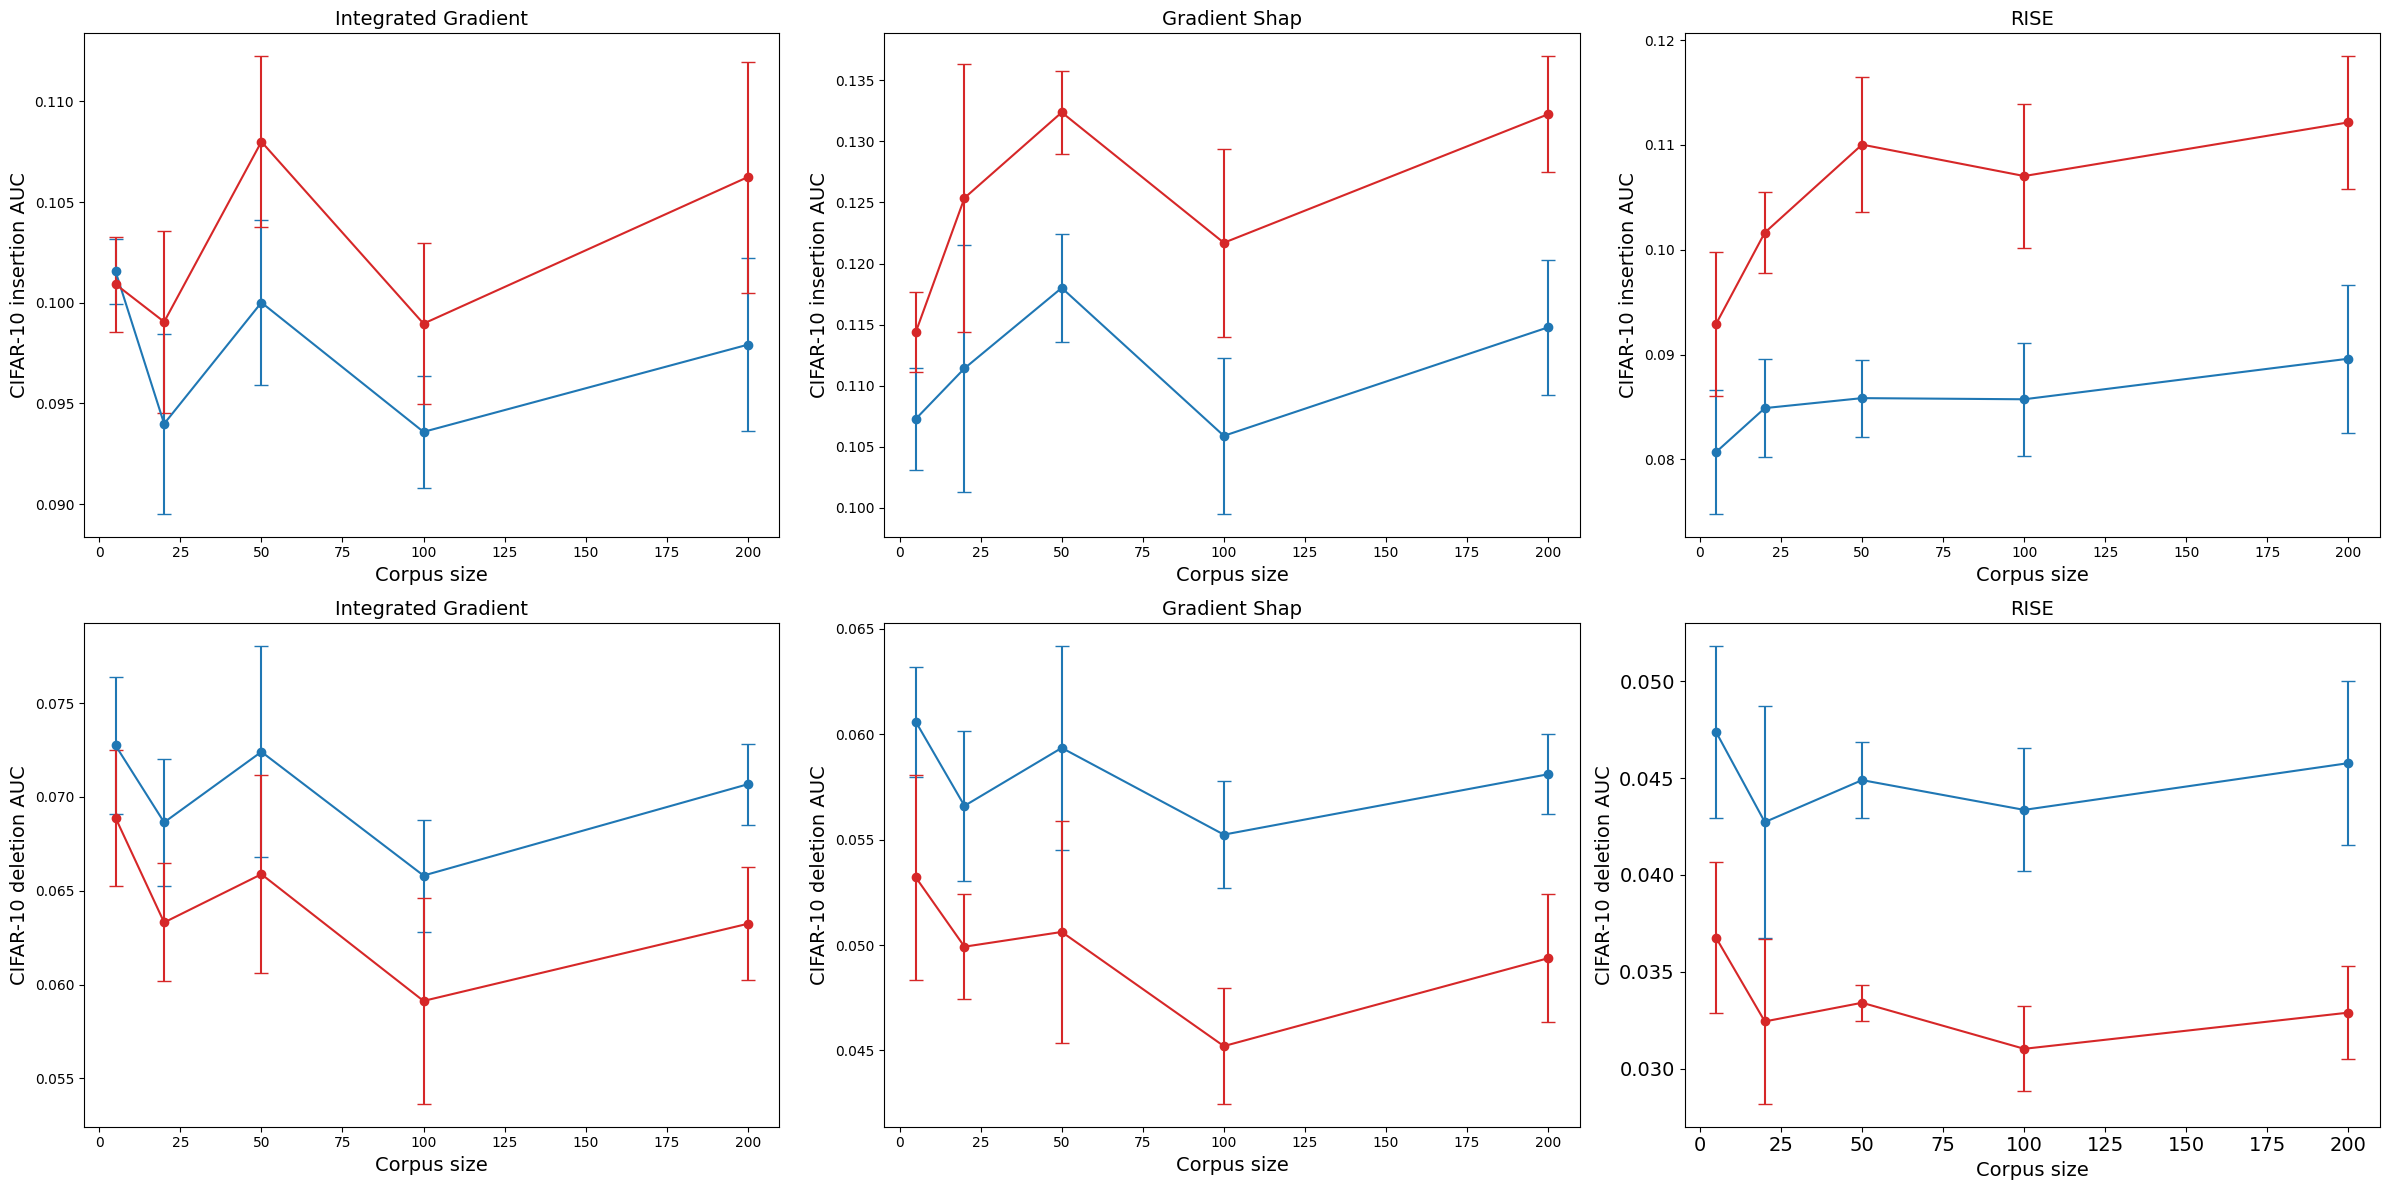

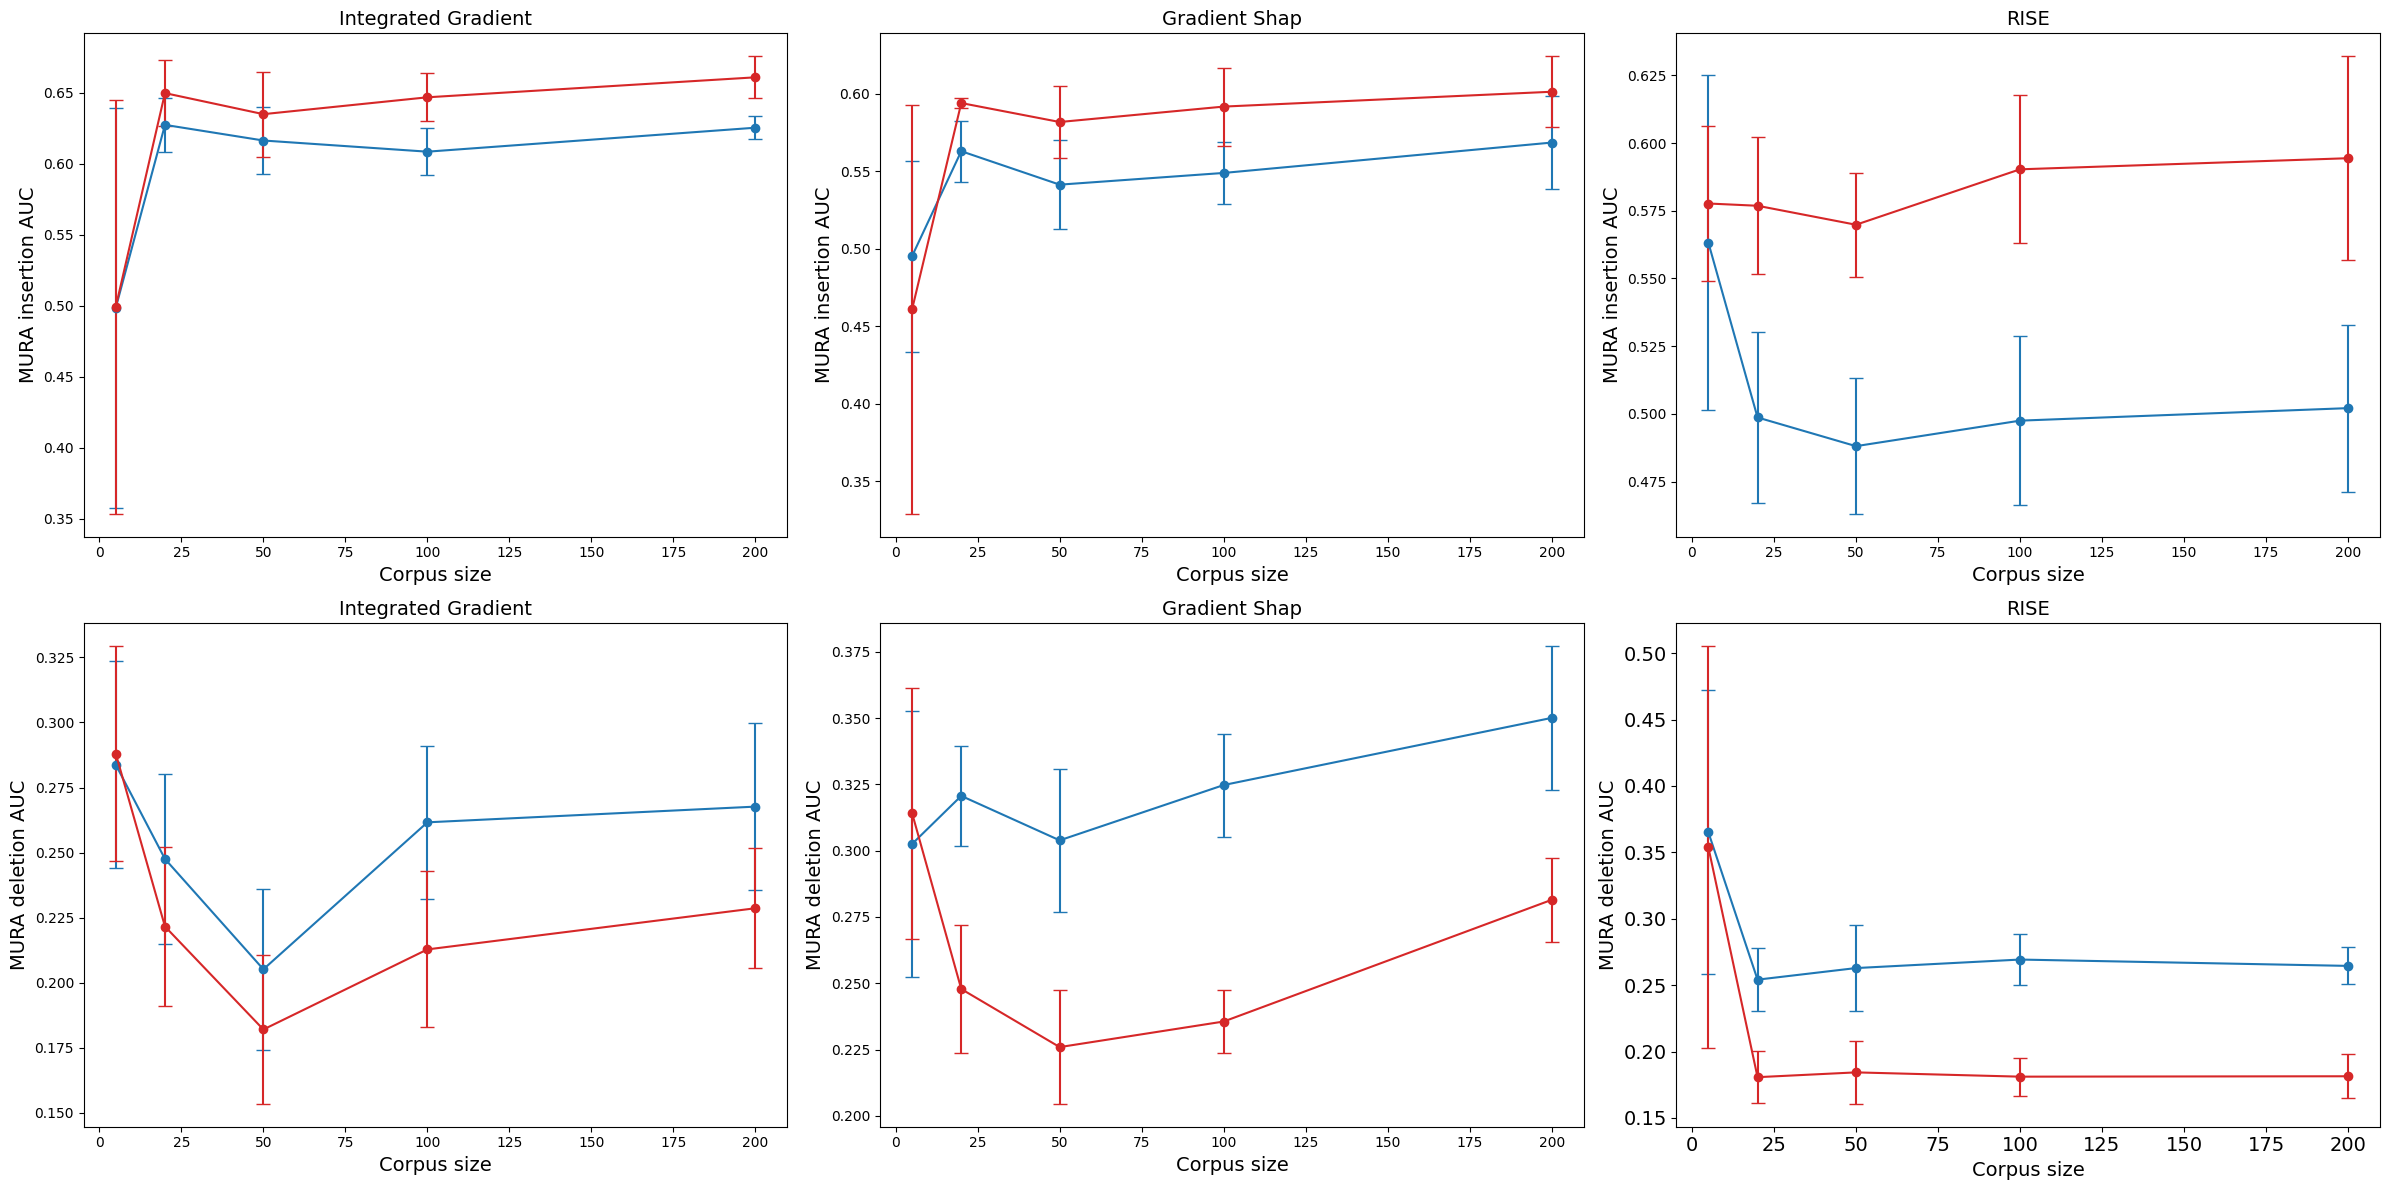

In [11]:
for i, dataset in enumerate(dataset_meta_dict.keys()):
    plot_extra = i == 0
    lineplot_results(
        dataset=dataset,
        eval_name="corpus_majority_prob",
        insertion_auc_dict=insertion_auc_dict,
        deletion_auc_dict=deletion_auc_dict,
        same_class=False,
        fontsize=14,
        plot_overall_title=plot_extra,
        plot_legend=plot_extra,
    )

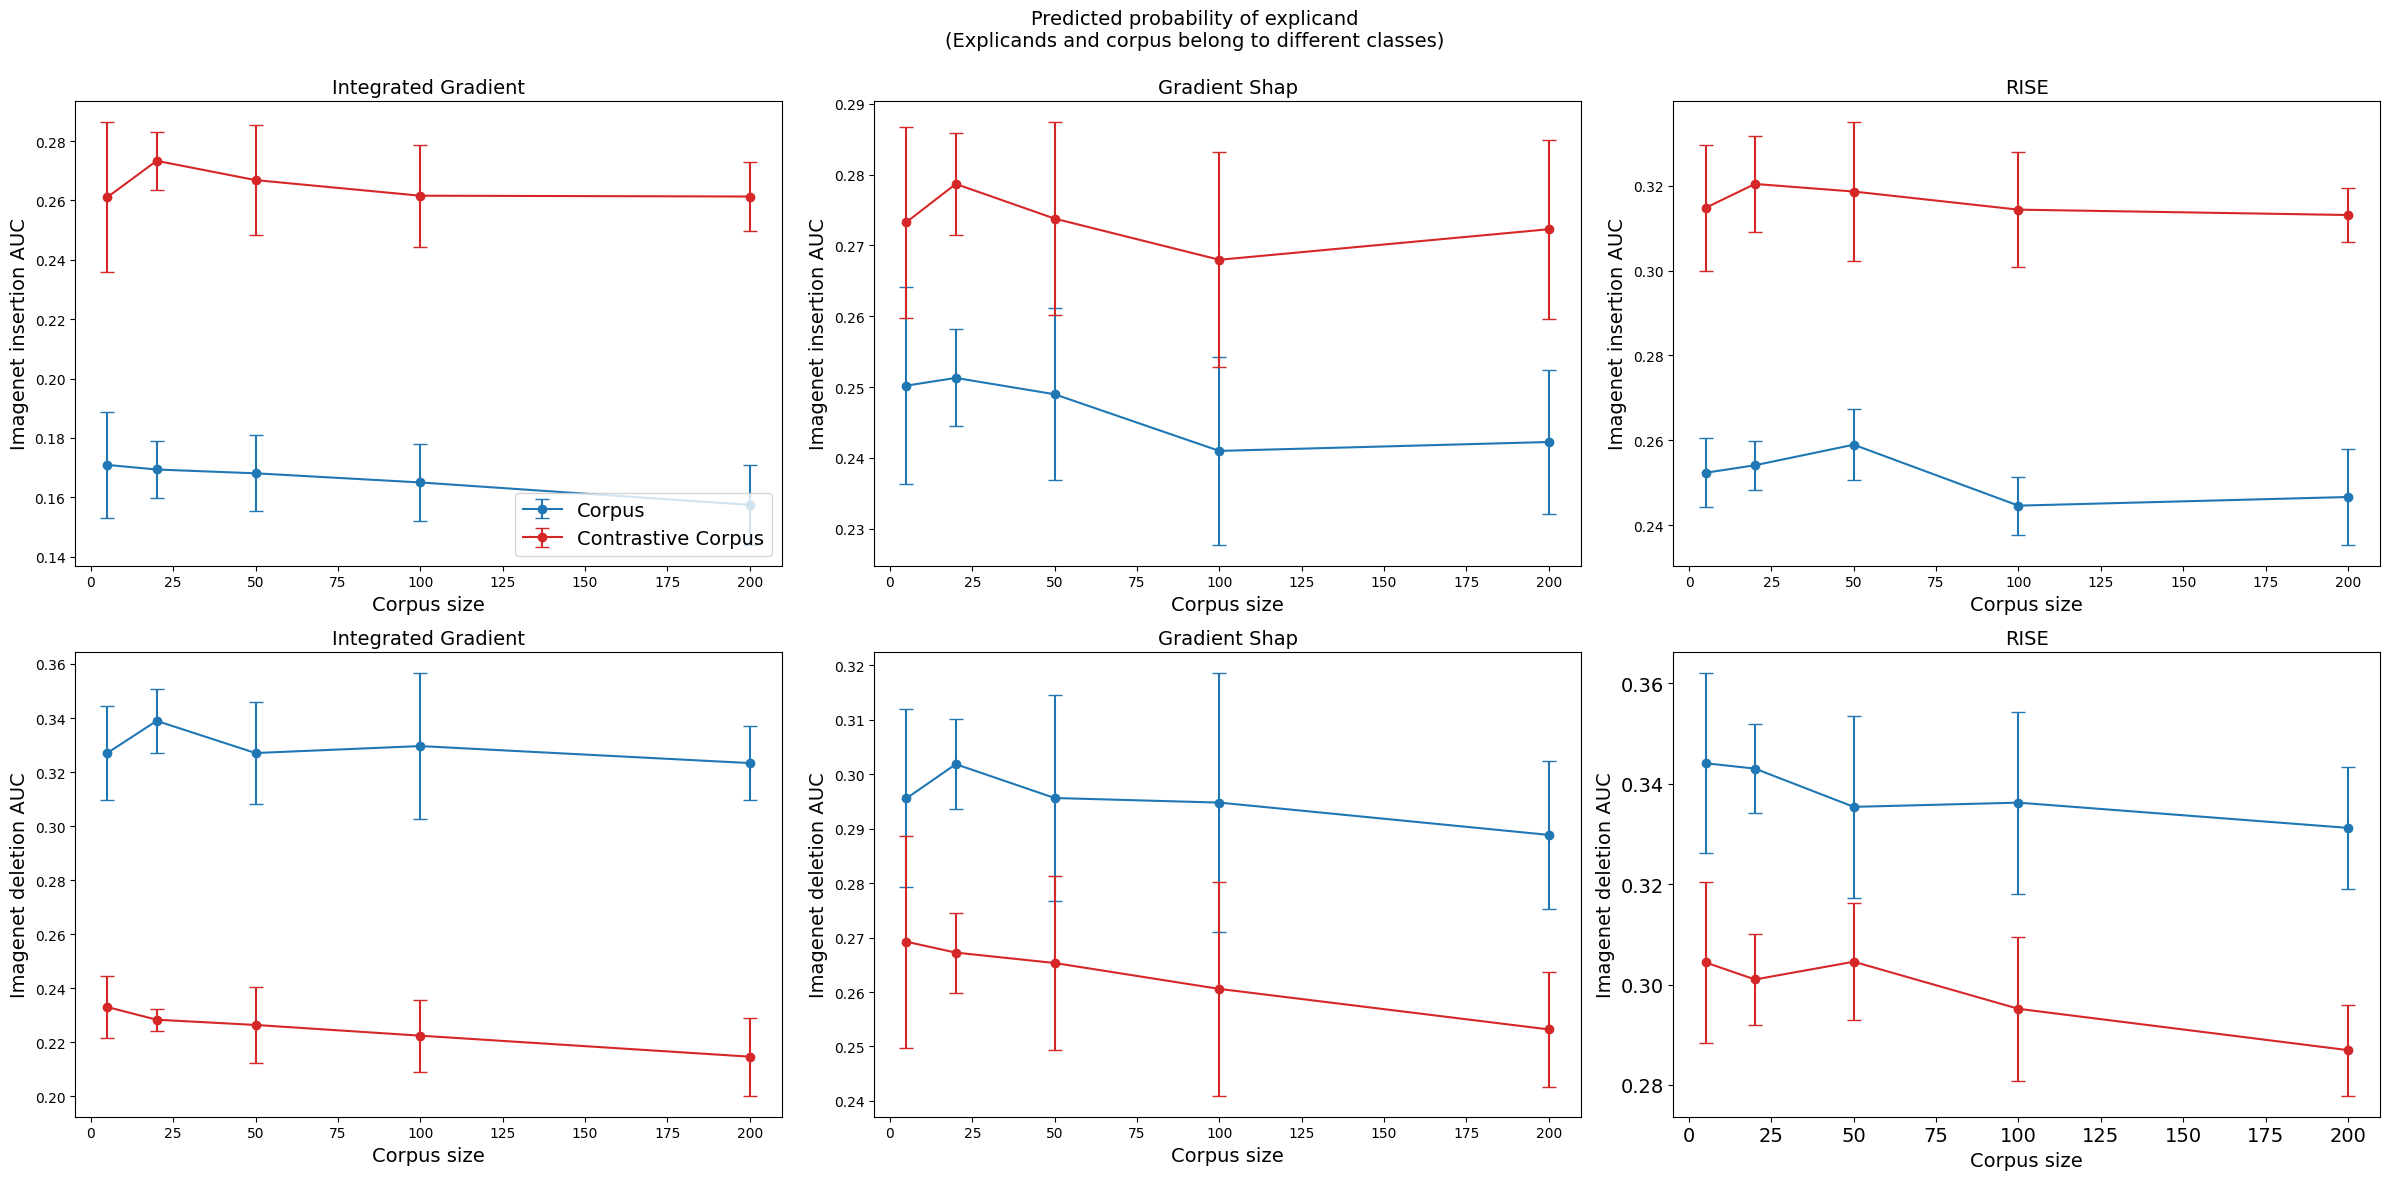

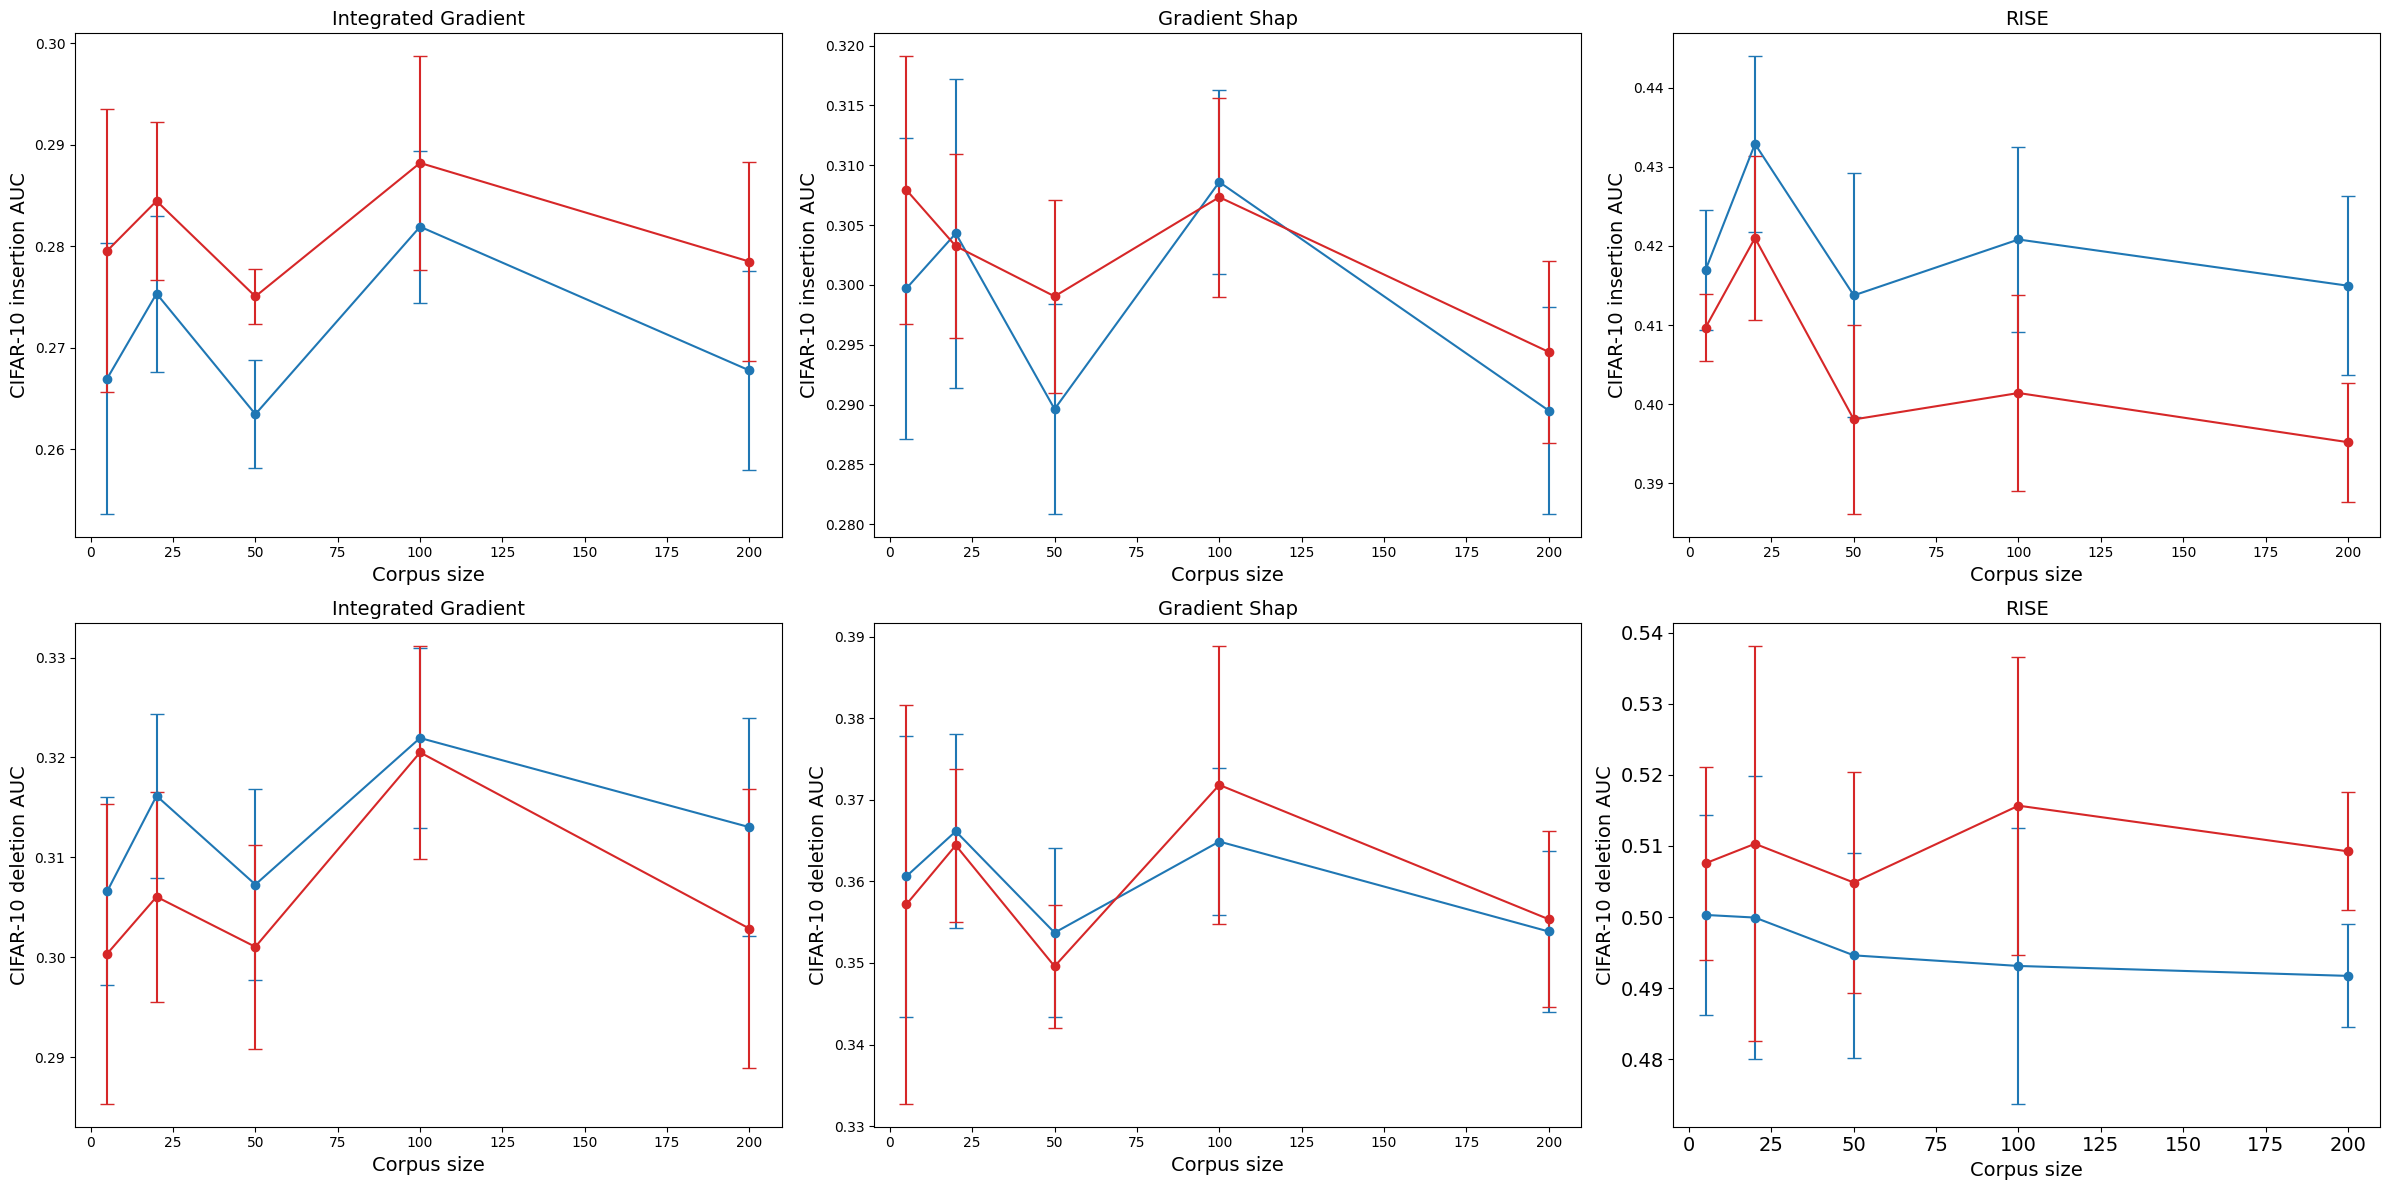

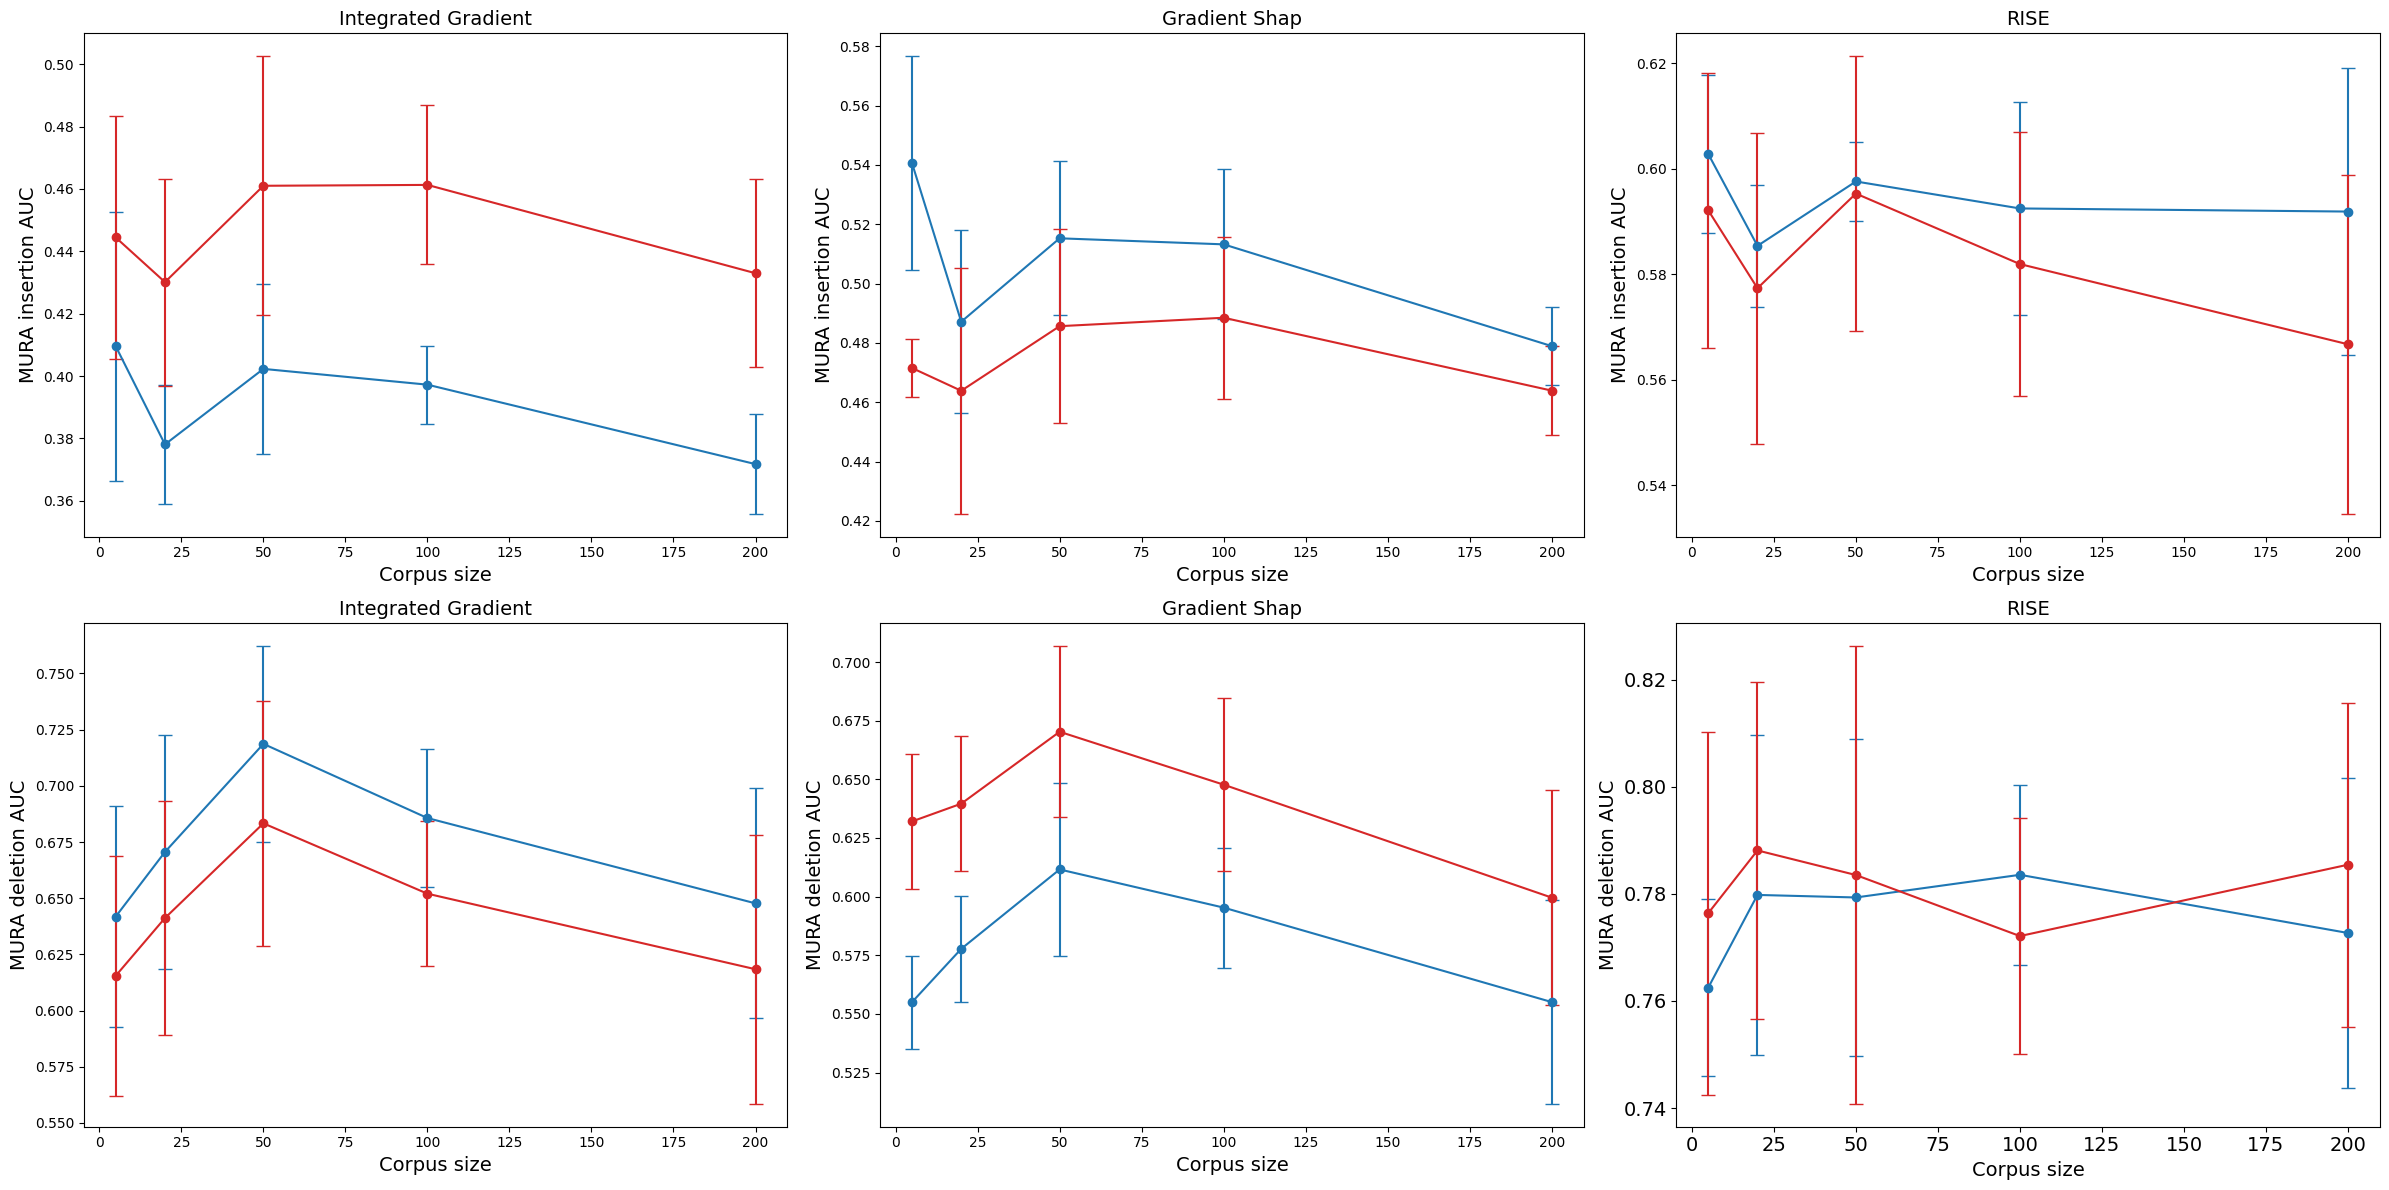

In [12]:
for i, dataset in enumerate(dataset_meta_dict.keys()):
    plot_extra = i == 0
    lineplot_results(
        dataset=dataset,
        eval_name="explicand_pred_prob",
        insertion_auc_dict=insertion_auc_dict,
        deletion_auc_dict=deletion_auc_dict,
        same_class=False,
        fontsize=14,
        plot_overall_title=plot_extra,
        plot_legend=plot_extra,
    )